In [2]:
import numpy as np
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import sys

C:\Users\Kozyrevsky-V\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def encode_lable(y, num_classes):
    y_gt = np.zeros((len(y), num_classes))
    for i in range(0, len(y)):
        y_gt[i, y[i]] = 1
    return y_gt

In [4]:
def h(theta, X):
    return 1.0 / (1 + np.exp(-np.dot(X, theta)))

In [5]:
def sigm_derivative(theta, X):
    return h(theta, X) * (1 - h(theta, X))

In [6]:
def loss(y_gt, y_pred):
    cross_entropy_error = 0.0
    for i in range(0, len(y_gt)):
        for j in range(0, len(y_gt[i])):
            cross_entropy_error -= (y_gt[i][j] * np.log(y_pred[i][j]) + (1 - y_gt[i][j]) * np.log(1 - y_pred[i][j]))
    return cross_entropy_error / len(y_gt)

In [7]:
def CEderivative(X, y_gt, y_pred):
    return np.dot(y_pred - y_gt, X) / len(y_gt)

In [8]:
def acc(y_test, y_out):
    accuracy = 0
    for i in range(len(y_out)):
        if np.argmax(y_test[i]) == np.argmax(y_out[i]):
            accuracy += 1
    return accuracy / len(y_test)

In [9]:
def RMSprob(Et_1, g, gamma, mu, e):
    Et = (gamma*Et_1) + (1-gamma)*(g**2)
    delta = (mu)/np.sqrt(Et + e)
    delta*=g
    return Et, delta 

In [25]:
def Adadelta(Et_1, g, gamma, RMS_1, e):
    Et = (gamma*Et_1) + (1-gamma)*(g**2)
    RMS = np.sqrt(Et + e)
    delta = (RMS_1/RMS)*g
    return Et, RMS, delta

In [10]:
def forward(thetas, X, dropout_prob, train_test_check):
    num_layers = thetas.shape[0]
    outs = []
    for t in range(0, num_layers): #проходим по всем слоям (все слои с сигмоидальной функцией активации)
        if t == 0:
            outs.append(np.array([h(thetas[t][:, i], X) for i in range(0, thetas[t].shape[1])]).T)
        else:
            outs.append(np.array([h(thetas[t][:, i], np.asarray(outs[t-1])) for i in range(0, thetas[t].shape[1])]).T)
    #Dropout
    if train_test_check:
        for i in range(len(outs) - 1):#для всех слоев кроме выходного и входного
            for o in outs[i]:
                o *= np.random.binomial(1,dropout_prob,o.shape[0]) * (1) / (dropout_prob)
    return [out for out in outs]

In [11]:
def backward(X, y_gt, thetas, dropout_prob):
    num_features = X.shape[1]
    num_classes = y_gt.shape[1]
    outs = forward(thetas, X,dropout_prob, True)
    num_layers = len(outs)
    d_theta = []
    d_theta.append(np.zeros([num_features, outs[0].shape[1]]))
    for i in range(0, num_layers - 1):
        d_theta.append(np.zeros([outs[i].shape[1], outs[i+1].shape[1]]))
    tmp_th = None
    #скрытые слои
    for i in range(len(outs) - 1, -1, -1):
        if i == len(outs) - 1:#выходной слой
            for class_no in range(0, num_classes):
                d_theta[i][:, class_no] = CEderivative(outs[i-1], y_gt[:, class_no], outs[i][:, class_no])
            tmp_th = outs[i] - y_gt
        elif i == 0:#первый скрытый
            tmp_th = np.dot(tmp_th, thetas[1].T)
            tmp_th = tmp_th * sigm_derivative(thetas[0], X)
            d_theta[0] = np.dot(X.T, tmp_th)
            d_theta[0] = d_theta[0]/outs[0].shape[0]
        else:# остальные скрытые
            tmp_th = np.dot(tmp_th, thetas[i+1].T)
            tmp_th = tmp_th * sigm_derivative(thetas[i], outs[i-1])
            d_theta[i] = np.dot(outs[i-1].T, tmp_th)
            d_theta[i] = d_theta[i]/outs[i].shape[0]
    return d_theta

In [12]:
(dx_train, dy_train), (x_test, y_test) = cifar10.load_data()

In [13]:
print('x_train shape:', dx_train.shape)
print(dx_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [14]:
dy_train = encode_lable(dy_train, 10)
y_test = encode_lable(y_test, 10)

In [15]:
dx_train = np.asarray([list(x.flat) for x in dx_train])
x_test = np.asarray([list(x.flat) for x in x_test])

In [16]:
p = np.random.permutation(dx_train.shape[0])
x_train = dx_train[p[0:int(len(dx_train)*0.8)], :]
y_train = dy_train[p[0:int(len(dx_train)*0.8)]]
x_val = dx_train[p[int(len(dx_train)*0.8):], :]
y_val = dy_train[p[int(len(dx_train)*0.8):]]
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (40000, 3072)
y_train shape: (40000, 10)
x_val shape: (10000, 3072)
y_val shape: (10000, 10)
x_test shape: (10000, 3072)
y_test shape: (10000, 10)


In [17]:
x_train = (x_train - np.mean(x_train, axis = 0)) / np.var(x_train, axis = 0)
x_val = (x_val - np.mean(x_val, axis = 0)) / np.var(x_val, axis = 0)
x_test = (x_test - np.mean(x_test, axis = 0)) / np.var(x_test, axis = 0)

In [18]:
def init_thetas(layers_size):
    np.random.seed(0)
    list_thetas = []
    for i in range(0, len(layers_size)-2):
        list_thetas.append(np.random.uniform(-1*pow(layers_size[i+1], (1/float(layers_size[i]))), pow(layers_size[i+1], (1/float(layers_size[i]))), (layers_size[i], layers_size[i+1])))
    list_thetas.append(np.random.uniform(-0.5, 0.5,(layers_size[-2], layers_size[-1])))
    return np.asarray(list_thetas)

In [19]:
def another_init_thetas(layers_size):
    list_thetas = []
    for i in range(0, len(layers_size) - 1):
        r = (4*(6/(layers_size[i] + layers_size[i+1]))**1/2)
        list_thetas.append(np.random.uniform(-1*r, r, (layers_size[i], layers_size[i+1])))
    return np.asarray(list_thetas)

Initial loss : 9.232694140616243


Epoch 0/500 ..............
Loss train:  4.519496229346358 
Loss val:  4.547718891323527 
Train accuracy:  0.14455 
Validation accuracy:  0.1417
Alpha:  0.1


Epoch 1/500 ..............
Loss train:  3.2950931137378436 
Loss val:  3.290806584633905 
Train accuracy:  0.18895 
Validation accuracy:  0.1887
Alpha:  0.1


Epoch 2/500 ..............
Loss train:  3.0780177447046144 
Loss val:  3.093218174677035 
Train accuracy:  0.2235 
Validation accuracy:  0.2158
Alpha:  0.1


Epoch 3/500 ..............
Loss train:  3.0182210058901577 
Loss val:  3.013945560150925 
Train accuracy:  0.259075 
Validation accuracy:  0.2616
Alpha:  0.1


Epoch 4/500 ..............
Loss train:  2.952694643634934 
Loss val:  2.9600392283355457 
Train accuracy:  0.28395 
Validation accuracy:  0.2775
Alpha:  0.1


Epoch 5/500 ..............
Loss train:  2.898685146203152 
Loss val:  2.902599080629327 
Train accuracy:  0.2901 
Validation accuracy:  0.2884
Alpha:  0.1


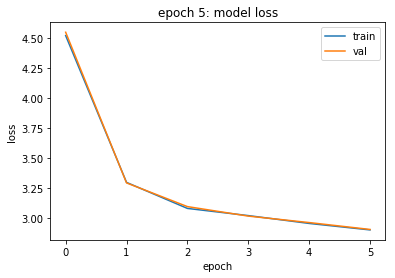

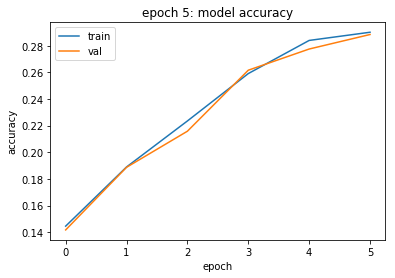



Epoch 6/500 ..............
Loss train:  2.9390852809942873 
Loss val:  2.943576720330009 
Train accuracy:  0.27545 
Validation accuracy:  0.274
Alpha:  0.1


Epoch 7/500 ..............
Loss train:  2.868038986196897 
Loss val:  2.869973857312205 
Train accuracy:  0.307225 
Validation accuracy:  0.3084
Alpha:  0.05


Epoch 8/500 ..............
Loss train:  2.8794455818185605 
Loss val:  2.87813180998005 
Train accuracy:  0.2986 
Validation accuracy:  0.2991
Alpha:  0.05


Epoch 9/500 ..............
Loss train:  2.8480002021748403 
Loss val:  2.853715793665747 
Train accuracy:  0.308225 
Validation accuracy:  0.3081
Alpha:  0.025


Epoch 10/500 ..............
Loss train:  2.8361519524204266 
Loss val:  2.8426659664024294 
Train accuracy:  0.31945 
Validation accuracy:  0.3164
Alpha:  0.025


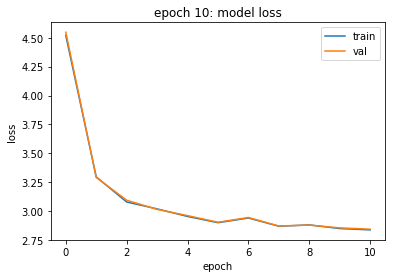

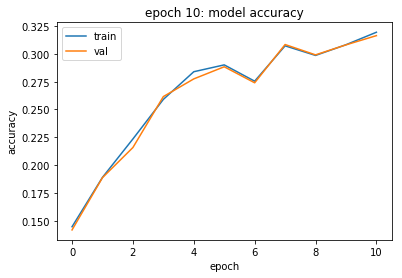



Epoch 11/500 ..............
Loss train:  2.831580816864984 
Loss val:  2.8396854375751555 
Train accuracy:  0.322825 
Validation accuracy:  0.3184
Alpha:  0.025


Epoch 12/500 ..............
Loss train:  2.830721351101969 
Loss val:  2.8373946799355654 
Train accuracy:  0.309825 
Validation accuracy:  0.2999
Alpha:  0.025


Epoch 13/500 ..............
Loss train:  2.8022661057398492 
Loss val:  2.8128681017096007 
Train accuracy:  0.330975 
Validation accuracy:  0.3173
Alpha:  0.025


Epoch 14/500 ..............
Loss train:  2.7986491193781746 
Loss val:  2.810808972387948 
Train accuracy:  0.329975 
Validation accuracy:  0.3245
Alpha:  0.025


Epoch 15/500 ..............
Loss train:  2.7932691620220003 
Loss val:  2.7997743005955718 
Train accuracy:  0.328 
Validation accuracy:  0.3257
Alpha:  0.025


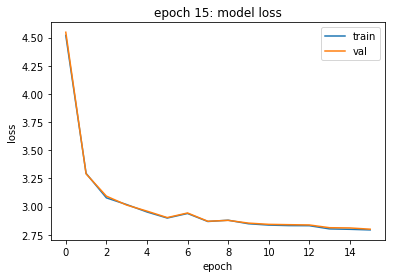

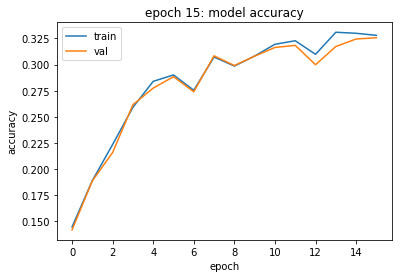



Epoch 16/500 ..............
Loss train:  2.7805907079974337 
Loss val:  2.7908271208955693 
Train accuracy:  0.338975 
Validation accuracy:  0.3397
Alpha:  0.025


Epoch 17/500 ..............
Loss train:  2.7698546567558124 
Loss val:  2.7783302662528224 
Train accuracy:  0.345725 
Validation accuracy:  0.3371
Alpha:  0.025


Epoch 18/500 ..............
Loss train:  2.772116207399372 
Loss val:  2.782364099052238 
Train accuracy:  0.336775 
Validation accuracy:  0.3341
Alpha:  0.025


Epoch 19/500 ..............
Loss train:  2.769904873946809 
Loss val:  2.781310877937109 
Train accuracy:  0.3386 
Validation accuracy:  0.3322
Alpha:  0.0125


Epoch 20/500 ..............
Loss train:  2.7483596198313784 
Loss val:  2.7579372148991297 
Train accuracy:  0.3482 
Validation accuracy:  0.3438
Alpha:  0.0125


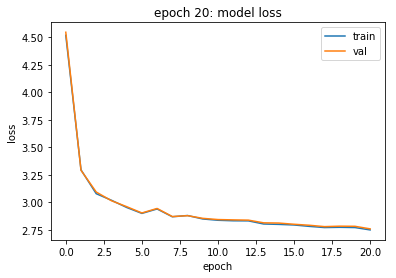

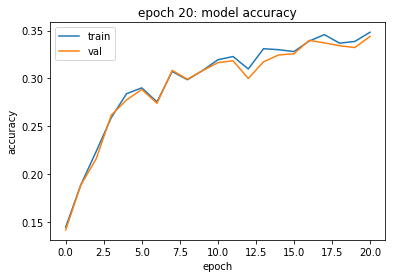



Epoch 21/500 ..............
Loss train:  2.7494905589707725 
Loss val:  2.7653678270977036 
Train accuracy:  0.34225 
Validation accuracy:  0.3349
Alpha:  0.0125


Epoch 22/500 ..............
Loss train:  2.734919110864915 
Loss val:  2.7461225300873875 
Train accuracy:  0.352125 
Validation accuracy:  0.3502
Alpha:  0.00625


Epoch 23/500 ..............
Loss train:  2.7265811607733204 
Loss val:  2.7380001391811644 
Train accuracy:  0.35485 
Validation accuracy:  0.3515
Alpha:  0.00625


Epoch 24/500 ..............
Loss train:  2.7194338158502926 
Loss val:  2.733660876018009 
Train accuracy:  0.3562 
Validation accuracy:  0.351
Alpha:  0.00625


Epoch 25/500 ..............
Loss train:  2.7208243627893762 
Loss val:  2.731619479020896 
Train accuracy:  0.358 
Validation accuracy:  0.3525
Alpha:  0.00625


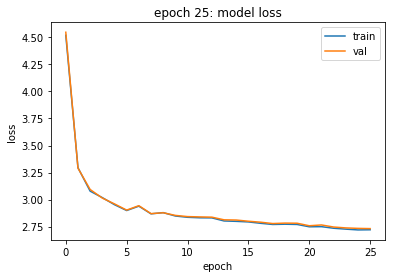

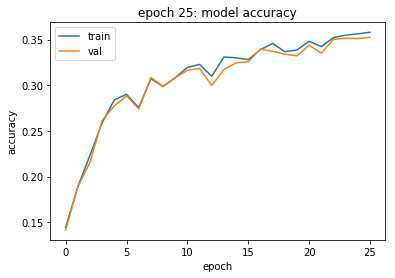



Epoch 26/500 ..............
Loss train:  2.7169619759640797 
Loss val:  2.728797543472727 
Train accuracy:  0.359175 
Validation accuracy:  0.3542
Alpha:  0.00625


Epoch 27/500 ..............
Loss train:  2.7132273541204657 
Loss val:  2.7288567316325043 
Train accuracy:  0.356775 
Validation accuracy:  0.348
Alpha:  0.00625


Epoch 28/500 ..............
Loss train:  2.7241206565927403 
Loss val:  2.7387397968966956 
Train accuracy:  0.34375 
Validation accuracy:  0.3311
Alpha:  0.003125


Epoch 29/500 ..............
Loss train:  2.698064195377847 
Loss val:  2.709887563758819 
Train accuracy:  0.363225 
Validation accuracy:  0.3597
Alpha:  0.0015625


Epoch 30/500 ..............
Loss train:  2.691455573291001 
Loss val:  2.707290034593778 
Train accuracy:  0.36485 
Validation accuracy:  0.36
Alpha:  0.0015625


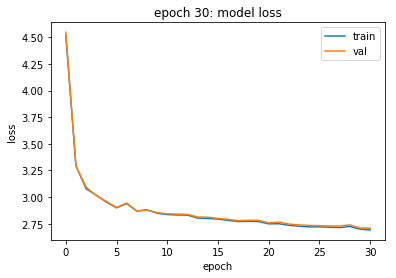

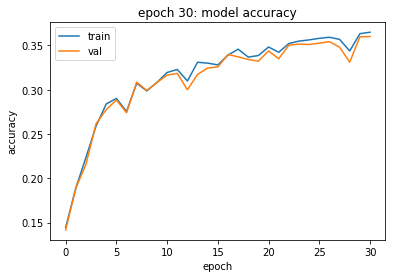



Epoch 31/500 ..............
Loss train:  2.679043282953538 
Loss val:  2.6936503564219327 
Train accuracy:  0.3688 
Validation accuracy:  0.361
Alpha:  0.0015625


Epoch 32/500 ..............
Loss train:  2.679521866442295 
Loss val:  2.6975991222454256 
Train accuracy:  0.368 
Validation accuracy:  0.3579
Alpha:  0.0015625


Epoch 33/500 ..............
Loss train:  2.6730371331392617 
Loss val:  2.686059325828026 
Train accuracy:  0.371975 
Validation accuracy:  0.3652
Alpha:  0.001


Epoch 34/500 ..............
Loss train:  2.6650454100065173 
Loss val:  2.68173042924146 
Train accuracy:  0.371575 
Validation accuracy:  0.3658
Alpha:  0.001


Epoch 35/500 ..............
Loss train:  2.6772556816105517 
Loss val:  2.6977504050042467 
Train accuracy:  0.359475 
Validation accuracy:  0.3515
Alpha:  0.001


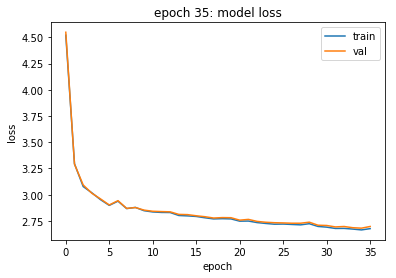

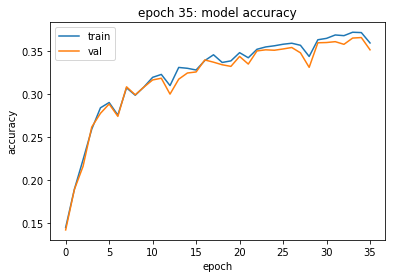



Epoch 36/500 ..............
Loss train:  2.665404376792753 
Loss val:  2.68195948002381 
Train accuracy:  0.374875 
Validation accuracy:  0.3701
Alpha:  0.001


Epoch 37/500 ..............
Loss train:  2.6643550339672424 
Loss val:  2.6794236240424834 
Train accuracy:  0.37505 
Validation accuracy:  0.3702
Alpha:  0.001


Epoch 38/500 ..............
Loss train:  2.6550957145289127 
Loss val:  2.669912648030274 
Train accuracy:  0.372075 
Validation accuracy:  0.3692
Alpha:  0.001


Epoch 39/500 ..............
Loss train:  2.6485990603133587 
Loss val:  2.6636688903608063 
Train accuracy:  0.377025 
Validation accuracy:  0.3735
Alpha:  0.001


Epoch 40/500 ..............
Loss train:  2.647047139175839 
Loss val:  2.6626803594776187 
Train accuracy:  0.3769 
Validation accuracy:  0.3715
Alpha:  0.001


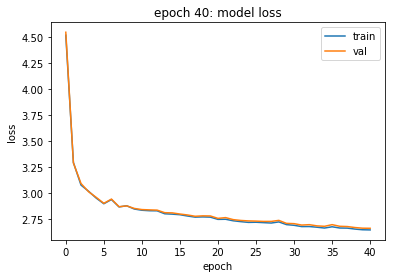

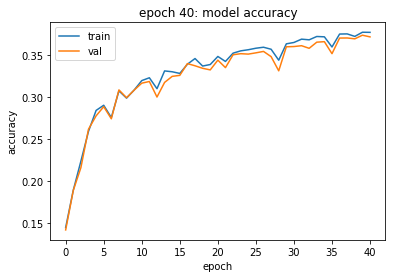



Epoch 41/500 ..............
Loss train:  2.638955017640547 
Loss val:  2.65382032919484 
Train accuracy:  0.380425 
Validation accuracy:  0.3781
Alpha:  0.001


Epoch 42/500 ..............
Loss train:  2.6412358629963126 
Loss val:  2.659060065525689 
Train accuracy:  0.381725 
Validation accuracy:  0.3764
Alpha:  0.001


Epoch 43/500 ..............
Loss train:  2.626182257550051 
Loss val:  2.647442522075007 
Train accuracy:  0.38375 
Validation accuracy:  0.3756
Alpha:  0.001


Epoch 44/500 ..............
Loss train:  2.6321571360263305 
Loss val:  2.6526582862520813 
Train accuracy:  0.382975 
Validation accuracy:  0.3761
Alpha:  0.001


Epoch 45/500 ..............
Loss train:  2.6217786996079133 
Loss val:  2.639854577047395 
Train accuracy:  0.384675 
Validation accuracy:  0.3796
Alpha:  0.001


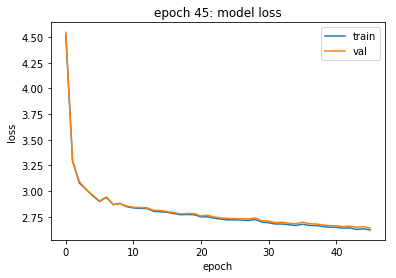

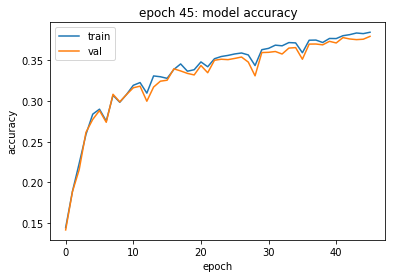



Epoch 46/500 ..............
Loss train:  2.6392845908603393 
Loss val:  2.6618823221799017 
Train accuracy:  0.37385 
Validation accuracy:  0.3639
Alpha:  0.001


Epoch 47/500 ..............
Loss train:  2.6234839960231673 
Loss val:  2.645577397341355 
Train accuracy:  0.38425 
Validation accuracy:  0.3776
Alpha:  0.001


Epoch 48/500 ..............
Loss train:  2.611609711417085 
Loss val:  2.6319998152371085 
Train accuracy:  0.385975 
Validation accuracy:  0.382
Alpha:  0.001


Epoch 49/500 ..............
Loss train:  2.602682012734778 
Loss val:  2.6240850393338895 
Train accuracy:  0.391925 
Validation accuracy:  0.3851
Alpha:  0.001


Epoch 50/500 ..............
Loss train:  2.603013353562433 
Loss val:  2.625233941660955 
Train accuracy:  0.3914 
Validation accuracy:  0.3806
Alpha:  0.001


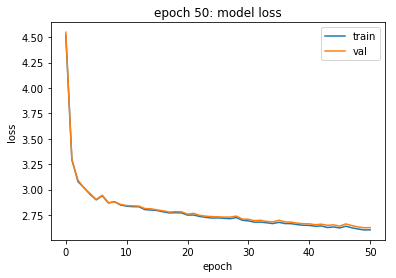

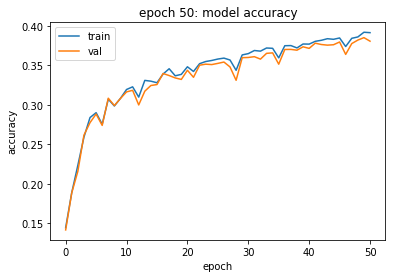



Epoch 51/500 ..............
Loss train:  2.596542063441028 
Loss val:  2.6182936662970753 
Train accuracy:  0.391525 
Validation accuracy:  0.3851
Alpha:  0.001


Epoch 52/500 ..............
Loss train:  2.589593410036244 
Loss val:  2.6125212631011965 
Train accuracy:  0.3934 
Validation accuracy:  0.3873
Alpha:  0.001


Epoch 53/500 ..............
Loss train:  2.598145917935161 
Loss val:  2.622299578149653 
Train accuracy:  0.388425 
Validation accuracy:  0.3825
Alpha:  0.001


Epoch 54/500 ..............
Loss train:  2.5846851548809138 
Loss val:  2.6058101240208025 
Train accuracy:  0.3971 
Validation accuracy:  0.3883
Alpha:  0.001


Epoch 55/500 ..............
Loss train:  2.58218425513157 
Loss val:  2.6081178975479737 
Train accuracy:  0.3957 
Validation accuracy:  0.3827
Alpha:  0.001


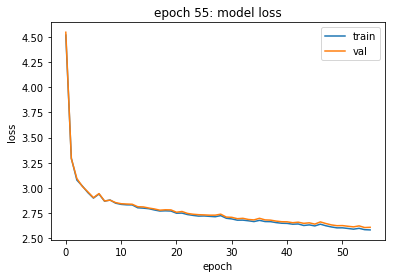

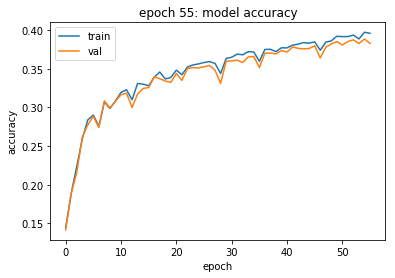



Epoch 56/500 ..............
Loss train:  2.5792788437267977 
Loss val:  2.601172635797318 
Train accuracy:  0.397175 
Validation accuracy:  0.3898
Alpha:  0.001


Epoch 57/500 ..............
Loss train:  2.5868559437438026 
Loss val:  2.6114141940900417 
Train accuracy:  0.39455 
Validation accuracy:  0.3884
Alpha:  0.001


Epoch 58/500 ..............
Loss train:  2.5869799038713635 
Loss val:  2.613174961864871 
Train accuracy:  0.38945 
Validation accuracy:  0.3812
Alpha:  0.001


Epoch 59/500 ..............
Loss train:  2.571374051173798 
Loss val:  2.5985379373707334 
Train accuracy:  0.397525 
Validation accuracy:  0.3864
Alpha:  0.001


Epoch 60/500 ..............
Loss train:  2.569270873884794 
Loss val:  2.596507584367262 
Train accuracy:  0.39675 
Validation accuracy:  0.3883
Alpha:  0.001


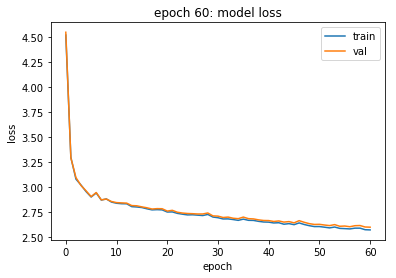

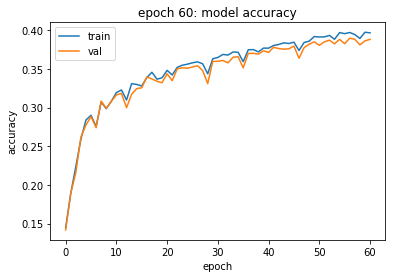



Epoch 61/500 ..............
Loss train:  2.570143083897437 
Loss val:  2.597977980661526 
Train accuracy:  0.398 
Validation accuracy:  0.3891
Alpha:  0.001


Epoch 62/500 ..............
Loss train:  2.5641272508774633 
Loss val:  2.5895477702470635 
Train accuracy:  0.40015 
Validation accuracy:  0.3941
Alpha:  0.001


Epoch 63/500 ..............
Loss train:  2.5573310721312836 
Loss val:  2.5824147837503513 
Train accuracy:  0.4038 
Validation accuracy:  0.392
Alpha:  0.001


Epoch 64/500 ..............
Loss train:  2.555345974814414 
Loss val:  2.5822639428565055 
Train accuracy:  0.4047 
Validation accuracy:  0.3938
Alpha:  0.001


Epoch 65/500 ..............
Loss train:  2.5518637662710577 
Loss val:  2.5762011498688646 
Train accuracy:  0.4052 
Validation accuracy:  0.3939
Alpha:  0.001


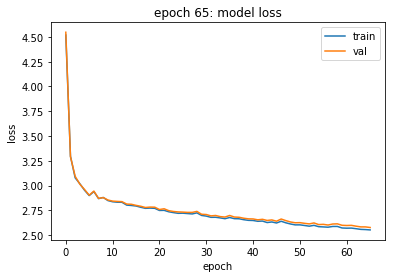

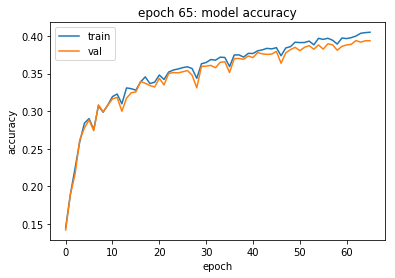



Epoch 66/500 ..............
Loss train:  2.548260312626159 
Loss val:  2.5740237098016254 
Train accuracy:  0.4065 
Validation accuracy:  0.3968
Alpha:  0.001


Epoch 67/500 ..............
Loss train:  2.5458083334752484 
Loss val:  2.574598997616966 
Train accuracy:  0.405675 
Validation accuracy:  0.3906
Alpha:  0.001


Epoch 68/500 ..............
Loss train:  2.543085781350019 
Loss val:  2.568780221900072 
Train accuracy:  0.4084 
Validation accuracy:  0.3978
Alpha:  0.001


Epoch 69/500 ..............
Loss train:  2.537392964059848 
Loss val:  2.5639728903346897 
Train accuracy:  0.409875 
Validation accuracy:  0.3995
Alpha:  0.001


Epoch 70/500 ..............
Loss train:  2.550705999979 
Loss val:  2.573889997755124 
Train accuracy:  0.40435 
Validation accuracy:  0.3965
Alpha:  0.001


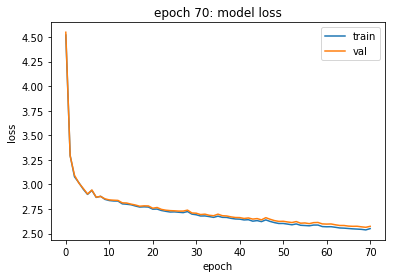

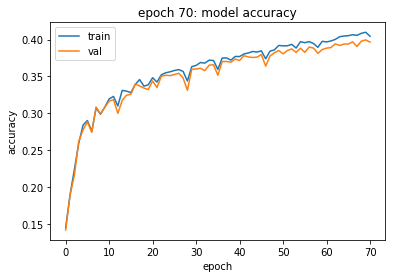



Epoch 71/500 ..............
Loss train:  2.53832470670574 
Loss val:  2.5665984871497844 
Train accuracy:  0.40885 
Validation accuracy:  0.3946
Alpha:  0.001


Epoch 72/500 ..............
Loss train:  2.530031140329067 
Loss val:  2.556442226442464 
Train accuracy:  0.4129 
Validation accuracy:  0.4014
Alpha:  0.001


Epoch 73/500 ..............
Loss train:  2.5334729626584815 
Loss val:  2.561945457386859 
Train accuracy:  0.411025 
Validation accuracy:  0.3994
Alpha:  0.001


Epoch 74/500 ..............
Loss train:  2.5331101289887816 
Loss val:  2.5612214870484062 
Train accuracy:  0.41165 
Validation accuracy:  0.3988
Alpha:  0.001


Epoch 75/500 ..............
Loss train:  2.529542185800012 
Loss val:  2.5590032000625493 
Train accuracy:  0.410375 
Validation accuracy:  0.3994
Alpha:  0.001


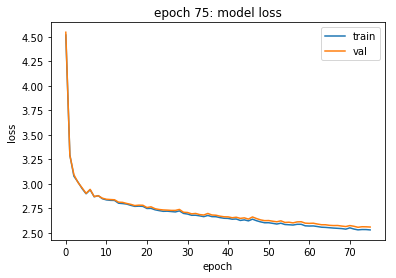

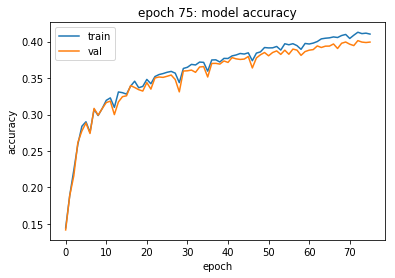



Epoch 76/500 ..............
Loss train:  2.5194984197975105 
Loss val:  2.550125310326955 
Train accuracy:  0.4154 
Validation accuracy:  0.4046
Alpha:  0.001


Epoch 77/500 ..............
Loss train:  2.525882790492895 
Loss val:  2.5534980391864965 
Train accuracy:  0.41145 
Validation accuracy:  0.4013
Alpha:  0.001


Epoch 78/500 ..............
Loss train:  2.520758020775439 
Loss val:  2.54859159869521 
Train accuracy:  0.41235 
Validation accuracy:  0.4039
Alpha:  0.001


Epoch 79/500 ..............
Loss train:  2.5185951941021245 
Loss val:  2.5483281078738425 
Train accuracy:  0.41625 
Validation accuracy:  0.4072
Alpha:  0.001


Epoch 80/500 ..............
Loss train:  2.515761320598448 
Loss val:  2.5457215793122536 
Train accuracy:  0.416525 
Validation accuracy:  0.4036
Alpha:  0.001


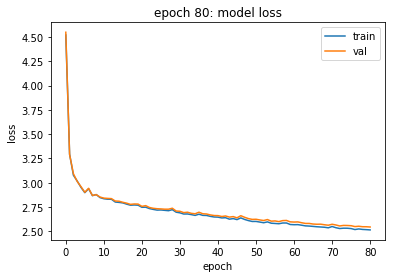

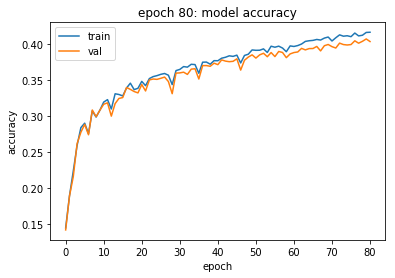



Epoch 81/500 ..............
Loss train:  2.5173906742376757 
Loss val:  2.546743751719477 
Train accuracy:  0.4131 
Validation accuracy:  0.4059
Alpha:  0.001


Epoch 82/500 ..............
Loss train:  2.510994434807035 
Loss val:  2.5390639772356507 
Train accuracy:  0.4186 
Validation accuracy:  0.4076
Alpha:  0.001


Epoch 83/500 ..............
Loss train:  2.5060140629129384 
Loss val:  2.537441083761411 
Train accuracy:  0.4172 
Validation accuracy:  0.4046
Alpha:  0.001


Epoch 84/500 ..............
Loss train:  2.5107181700631234 
Loss val:  2.536488502706427 
Train accuracy:  0.41805 
Validation accuracy:  0.4114
Alpha:  0.001


Epoch 85/500 ..............
Loss train:  2.508346867588614 
Loss val:  2.537848908580499 
Train accuracy:  0.415125 
Validation accuracy:  0.4044
Alpha:  0.001


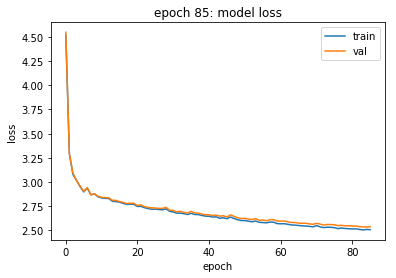

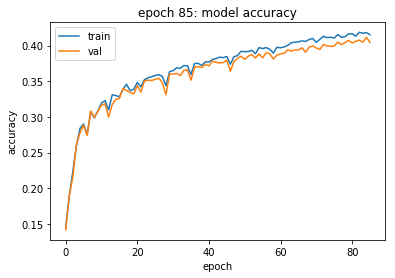



Epoch 86/500 ..............
Loss train:  2.5032013744250476 
Loss val:  2.5336612353700256 
Train accuracy:  0.42075 
Validation accuracy:  0.4084
Alpha:  0.001


Epoch 87/500 ..............
Loss train:  2.504994913965964 
Loss val:  2.5346250711557516 
Train accuracy:  0.419575 
Validation accuracy:  0.4092
Alpha:  0.001


Epoch 88/500 ..............
Loss train:  2.4967838225784305 
Loss val:  2.52634929061704 
Train accuracy:  0.4193 
Validation accuracy:  0.4098
Alpha:  0.001


Epoch 89/500 ..............
Loss train:  2.500731691650885 
Loss val:  2.5289423464018816 
Train accuracy:  0.41965 
Validation accuracy:  0.4112
Alpha:  0.001


Epoch 90/500 ..............
Loss train:  2.4926890254316323 
Loss val:  2.5238585256238033 
Train accuracy:  0.42125 
Validation accuracy:  0.4107
Alpha:  0.001


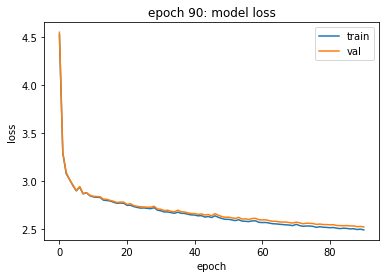

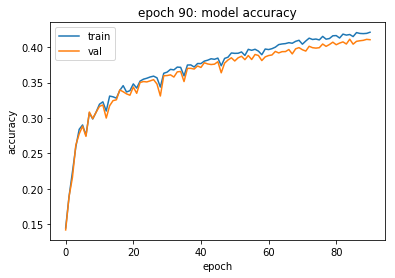



Epoch 91/500 ..............
Loss train:  2.4961891192234367 
Loss val:  2.5276883529103795 
Train accuracy:  0.420875 
Validation accuracy:  0.4143
Alpha:  0.001


Epoch 92/500 ..............
Loss train:  2.4876788602623088 
Loss val:  2.5165818158909583 
Train accuracy:  0.4228 
Validation accuracy:  0.4125
Alpha:  0.001


Epoch 93/500 ..............
Loss train:  2.4873782810655745 
Loss val:  2.5169663478384106 
Train accuracy:  0.42395 
Validation accuracy:  0.4104
Alpha:  0.001


Epoch 94/500 ..............
Loss train:  2.4903595995698864 
Loss val:  2.524927072518398 
Train accuracy:  0.422 
Validation accuracy:  0.4116
Alpha:  0.001


Epoch 95/500 ..............
Loss train:  2.486873702472651 
Loss val:  2.5198580114423526 
Train accuracy:  0.424275 
Validation accuracy:  0.4107
Alpha:  0.001


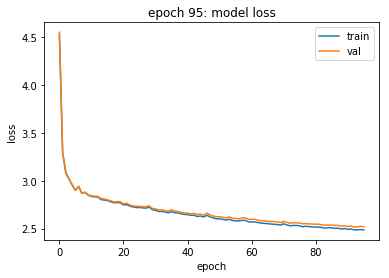

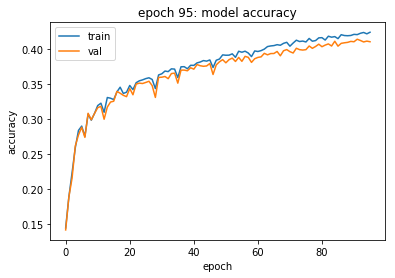



Epoch 96/500 ..............
Loss train:  2.485700614206843 
Loss val:  2.518999920767046 
Train accuracy:  0.4228 
Validation accuracy:  0.4078
Alpha:  0.001


Epoch 97/500 ..............
Loss train:  2.486079878968635 
Loss val:  2.518021198028582 
Train accuracy:  0.42175 
Validation accuracy:  0.4117
Alpha:  0.001


Epoch 98/500 ..............
Loss train:  2.473715997950204 
Loss val:  2.5071653908330367 
Train accuracy:  0.42765 
Validation accuracy:  0.4162
Alpha:  0.001


Epoch 99/500 ..............
Loss train:  2.4719332061133397 
Loss val:  2.502349661748233 
Train accuracy:  0.4286 
Validation accuracy:  0.4186
Alpha:  0.001


Epoch 100/500 ..............
Loss train:  2.4737193130797337 
Loss val:  2.5050912506306213 
Train accuracy:  0.42565 
Validation accuracy:  0.4189
Alpha:  0.001


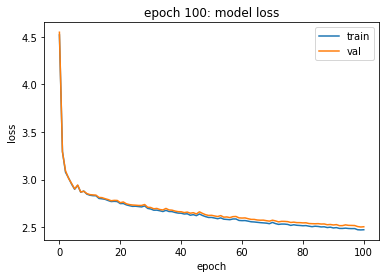

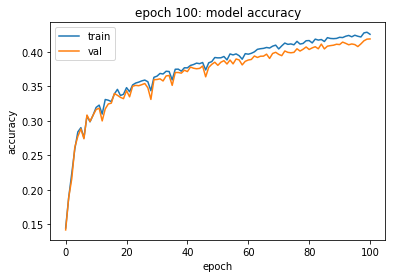



Epoch 101/500 ..............
Loss train:  2.4691300562498855 
Loss val:  2.5031442344351174 
Train accuracy:  0.428725 
Validation accuracy:  0.4189
Alpha:  0.001


Epoch 102/500 ..............
Loss train:  2.471425842609104 
Loss val:  2.506121903775581 
Train accuracy:  0.4275 
Validation accuracy:  0.4137
Alpha:  0.001


Epoch 103/500 ..............
Loss train:  2.468846447984047 
Loss val:  2.5022474303622104 
Train accuracy:  0.429125 
Validation accuracy:  0.4154
Alpha:  0.001


Epoch 104/500 ..............
Loss train:  2.4733553679016063 
Loss val:  2.511163941021652 
Train accuracy:  0.42495 
Validation accuracy:  0.4101
Alpha:  0.001


Epoch 105/500 ..............
Loss train:  2.469724927917579 
Loss val:  2.5051865573299086 
Train accuracy:  0.425375 
Validation accuracy:  0.4118
Alpha:  0.001


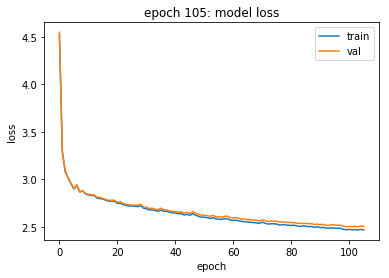

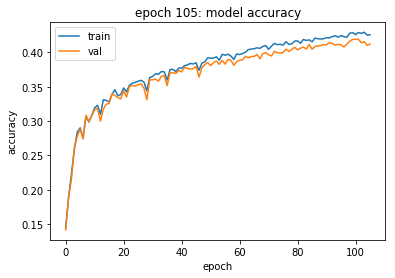



Epoch 106/500 ..............
Loss train:  2.462837620041637 
Loss val:  2.495100636020965 
Train accuracy:  0.430575 
Validation accuracy:  0.4214
Alpha:  0.001


Epoch 107/500 ..............
Loss train:  2.4567070783838756 
Loss val:  2.4915179303924537 
Train accuracy:  0.432275 
Validation accuracy:  0.4235
Alpha:  0.001


Epoch 108/500 ..............
Loss train:  2.4541283370522584 
Loss val:  2.4887785166118794 
Train accuracy:  0.433275 
Validation accuracy:  0.4236
Alpha:  0.001


Epoch 109/500 ..............
Loss train:  2.4538622073749226 
Loss val:  2.488531810643437 
Train accuracy:  0.43285 
Validation accuracy:  0.4205
Alpha:  0.001


Epoch 110/500 ..............
Loss train:  2.4562180599791446 
Loss val:  2.493023501799827 
Train accuracy:  0.43195 
Validation accuracy:  0.4208
Alpha:  0.001


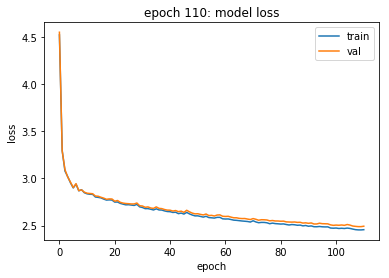

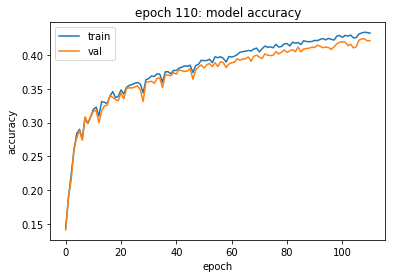



Epoch 111/500 ..............
Loss train:  2.455214186367047 
Loss val:  2.4901715854726456 
Train accuracy:  0.431575 
Validation accuracy:  0.4276
Alpha:  0.001


Epoch 112/500 ..............
Loss train:  2.4530460457644296 
Loss val:  2.4900802603512466 
Train accuracy:  0.43295 
Validation accuracy:  0.4208
Alpha:  0.001


Epoch 113/500 ..............
Loss train:  2.449136274182178 
Loss val:  2.48632300801947 
Train accuracy:  0.435825 
Validation accuracy:  0.4259
Alpha:  0.001


Epoch 114/500 ..............
Loss train:  2.447673420778955 
Loss val:  2.483593915972664 
Train accuracy:  0.432925 
Validation accuracy:  0.4264
Alpha:  0.001


Epoch 115/500 ..............
Loss train:  2.444039356855549 
Loss val:  2.480669385041461 
Train accuracy:  0.43605 
Validation accuracy:  0.4267
Alpha:  0.001


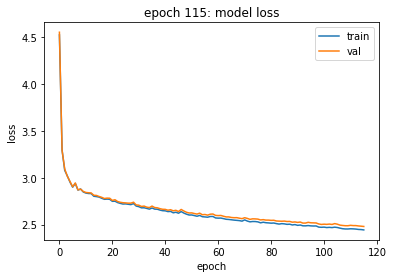

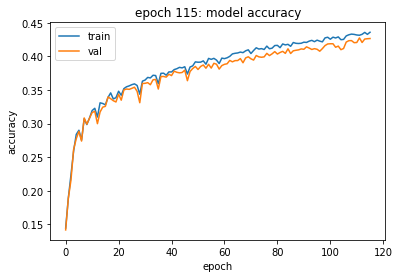



Epoch 116/500 ..............
Loss train:  2.4477337987947876 
Loss val:  2.4855186841420815 
Train accuracy:  0.43665 
Validation accuracy:  0.426
Alpha:  0.001


Epoch 117/500 ..............
Loss train:  2.447367701750223 
Loss val:  2.4851877903121045 
Train accuracy:  0.4342 
Validation accuracy:  0.4186
Alpha:  0.001


Epoch 118/500 ..............
Loss train:  2.4503507774881412 
Loss val:  2.483675961162053 
Train accuracy:  0.4328 
Validation accuracy:  0.4231
Alpha:  0.001


Epoch 119/500 ..............
Loss train:  2.4470499574012456 
Loss val:  2.4838642172727337 
Train accuracy:  0.43175 
Validation accuracy:  0.4253
Alpha:  0.001


Epoch 120/500 ..............
Loss train:  2.4441757609674157 
Loss val:  2.4848004941207855 
Train accuracy:  0.433825 
Validation accuracy:  0.4209
Alpha:  0.001


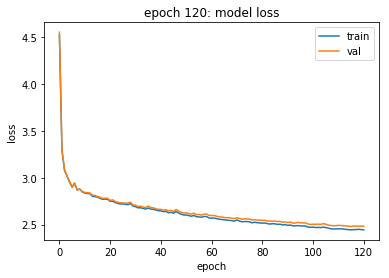

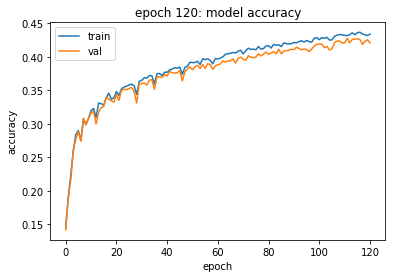



Epoch 121/500 ..............
Loss train:  2.4426700370306564 
Loss val:  2.4789384097606164 
Train accuracy:  0.43475 
Validation accuracy:  0.4267
Alpha:  0.001


Epoch 122/500 ..............
Loss train:  2.436205293064888 
Loss val:  2.4731096965113424 
Train accuracy:  0.43785 
Validation accuracy:  0.4319
Alpha:  0.001


Epoch 123/500 ..............
Loss train:  2.4346496705193283 
Loss val:  2.4722145597277807 
Train accuracy:  0.4395 
Validation accuracy:  0.429
Alpha:  0.001


Epoch 124/500 ..............
Loss train:  2.437495852806417 
Loss val:  2.4771299843413197 
Train accuracy:  0.437125 
Validation accuracy:  0.4232
Alpha:  0.001


Epoch 125/500 ..............
Loss train:  2.4336988183042996 
Loss val:  2.4712431066952836 
Train accuracy:  0.441125 
Validation accuracy:  0.4327
Alpha:  0.001


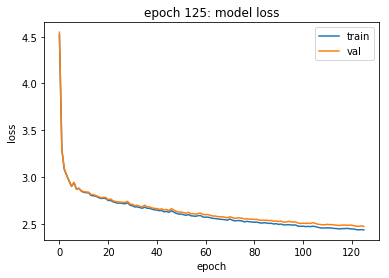

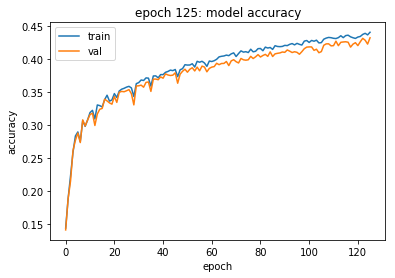



Epoch 126/500 ..............
Loss train:  2.4364175044301972 
Loss val:  2.4740665574429386 
Train accuracy:  0.4381 
Validation accuracy:  0.4279
Alpha:  0.001


Epoch 127/500 ..............
Loss train:  2.430050940235188 
Loss val:  2.4706286767935133 
Train accuracy:  0.4405 
Validation accuracy:  0.4337
Alpha:  0.001


Epoch 128/500 ..............
Loss train:  2.4275400501420874 
Loss val:  2.465618142772372 
Train accuracy:  0.4406 
Validation accuracy:  0.4304
Alpha:  0.001


Epoch 129/500 ..............
Loss train:  2.434644358319222 
Loss val:  2.4731664748964706 
Train accuracy:  0.43975 
Validation accuracy:  0.4303
Alpha:  0.001


Epoch 130/500 ..............
Loss train:  2.429002203662344 
Loss val:  2.4698289948643954 
Train accuracy:  0.4399 
Validation accuracy:  0.4313
Alpha:  0.001


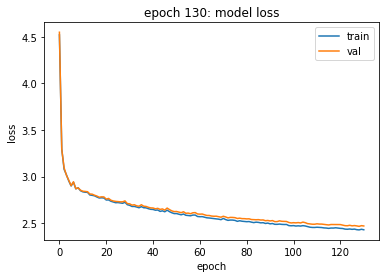

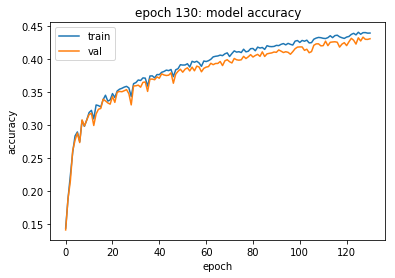



Epoch 131/500 ..............
Loss train:  2.4238066250318755 
Loss val:  2.4637119695282705 
Train accuracy:  0.442325 
Validation accuracy:  0.4289
Alpha:  0.001


Epoch 132/500 ..............
Loss train:  2.4298377331182803 
Loss val:  2.471798417188366 
Train accuracy:  0.4393 
Validation accuracy:  0.427
Alpha:  0.001


Epoch 133/500 ..............
Loss train:  2.4342701681848897 
Loss val:  2.4756162429314967 
Train accuracy:  0.438225 
Validation accuracy:  0.4288
Alpha:  0.001


Epoch 134/500 ..............
Loss train:  2.4279156393545303 
Loss val:  2.467381905022854 
Train accuracy:  0.43945 
Validation accuracy:  0.4289
Alpha:  0.001


Epoch 135/500 ..............
Loss train:  2.427571043873766 
Loss val:  2.466734648658277 
Train accuracy:  0.440175 
Validation accuracy:  0.4297
Alpha:  0.001


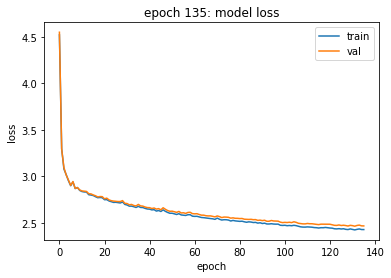

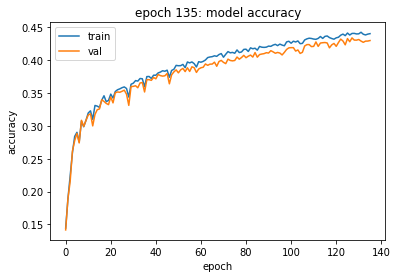



Epoch 136/500 ..............
Loss train:  2.425424795271655 
Loss val:  2.463416244813906 
Train accuracy:  0.439775 
Validation accuracy:  0.4328
Alpha:  0.001


Epoch 137/500 ..............
Loss train:  2.4180413533010263 
Loss val:  2.4606531704134924 
Train accuracy:  0.445 
Validation accuracy:  0.4301
Alpha:  0.001


Epoch 138/500 ..............
Loss train:  2.4184097974785486 
Loss val:  2.462161945296669 
Train accuracy:  0.442525 
Validation accuracy:  0.4253
Alpha:  0.001


Epoch 139/500 ..............
Loss train:  2.4198597028968294 
Loss val:  2.4606583002722133 
Train accuracy:  0.441475 
Validation accuracy:  0.4321
Alpha:  0.001


Epoch 140/500 ..............
Loss train:  2.4142950596683064 
Loss val:  2.4564229736816245 
Train accuracy:  0.444025 
Validation accuracy:  0.4351
Alpha:  0.001


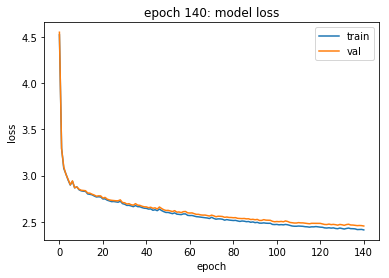

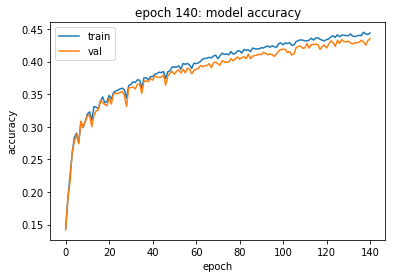



Epoch 141/500 ..............
Loss train:  2.413527725485888 
Loss val:  2.4564949771292404 
Train accuracy:  0.444025 
Validation accuracy:  0.432
Alpha:  0.001


Epoch 142/500 ..............
Loss train:  2.417739670546617 
Loss val:  2.4586453241969557 
Train accuracy:  0.4426 
Validation accuracy:  0.4294
Alpha:  0.001


Epoch 143/500 ..............
Loss train:  2.40968366674918 
Loss val:  2.4541299484988928 
Train accuracy:  0.446075 
Validation accuracy:  0.4326
Alpha:  0.001


Epoch 144/500 ..............
Loss train:  2.4094409737965967 
Loss val:  2.454312858077116 
Train accuracy:  0.445175 
Validation accuracy:  0.4354
Alpha:  0.001


Epoch 145/500 ..............
Loss train:  2.4076286769818833 
Loss val:  2.451270398300762 
Train accuracy:  0.4454 
Validation accuracy:  0.4353
Alpha:  0.001


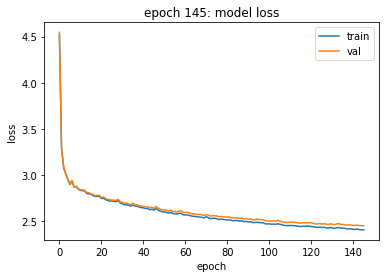

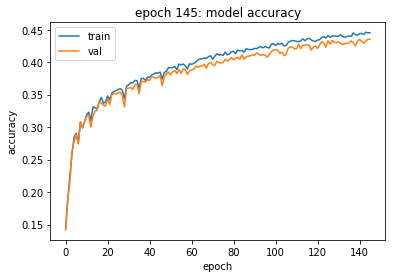



Epoch 146/500 ..............
Loss train:  2.4059325415412958 
Loss val:  2.4515459773504538 
Train accuracy:  0.4466 
Validation accuracy:  0.4357
Alpha:  0.001


Epoch 147/500 ..............
Loss train:  2.400138916026905 
Loss val:  2.4443031267298863 
Train accuracy:  0.448475 
Validation accuracy:  0.438
Alpha:  0.001


Epoch 148/500 ..............
Loss train:  2.4029554851625163 
Loss val:  2.4476766135156485 
Train accuracy:  0.44615 
Validation accuracy:  0.4362
Alpha:  0.001


Epoch 149/500 ..............
Loss train:  2.4050880777869117 
Loss val:  2.449282408933821 
Train accuracy:  0.446225 
Validation accuracy:  0.4352
Alpha:  0.001


Epoch 150/500 ..............
Loss train:  2.399372873281282 
Loss val:  2.441839272381722 
Train accuracy:  0.448 
Validation accuracy:  0.4352
Alpha:  0.001


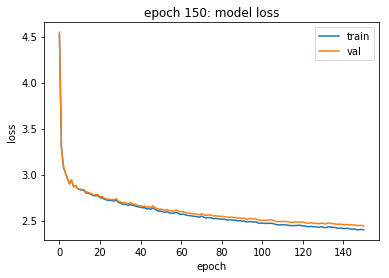

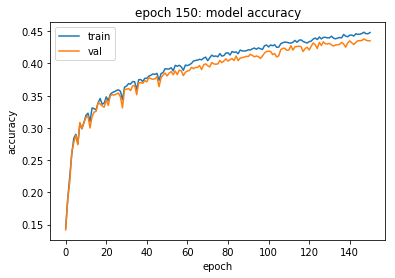



Epoch 151/500 ..............
Loss train:  2.4046797808039675 
Loss val:  2.451445202841695 
Train accuracy:  0.4461 
Validation accuracy:  0.4355
Alpha:  0.001


Epoch 152/500 ..............
Loss train:  2.4040462438656514 
Loss val:  2.4520184253667283 
Train accuracy:  0.448025 
Validation accuracy:  0.433
Alpha:  0.001


Epoch 153/500 ..............
Loss train:  2.397163313676924 
Loss val:  2.4428474006848533 
Train accuracy:  0.4493 
Validation accuracy:  0.4364
Alpha:  0.001


Epoch 154/500 ..............
Loss train:  2.39599039491832 
Loss val:  2.4421819005234644 
Train accuracy:  0.448425 
Validation accuracy:  0.4381
Alpha:  0.001


Epoch 155/500 ..............
Loss train:  2.3976735001407827 
Loss val:  2.444418841231235 
Train accuracy:  0.44885 
Validation accuracy:  0.4371
Alpha:  0.001


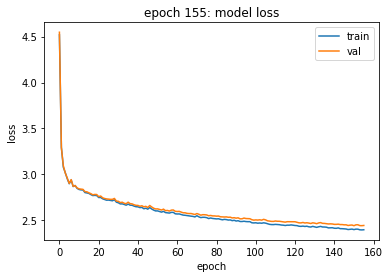

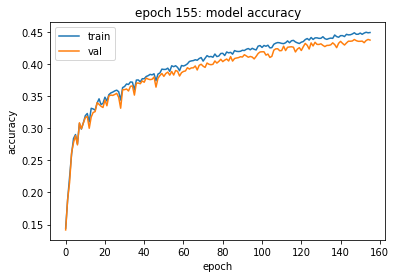



Epoch 156/500 ..............
Loss train:  2.3947185887709295 
Loss val:  2.4422666470975294 
Train accuracy:  0.44825 
Validation accuracy:  0.4376
Alpha:  0.001


Epoch 157/500 ..............
Loss train:  2.392745381375952 
Loss val:  2.4383274524427643 
Train accuracy:  0.4516 
Validation accuracy:  0.4373
Alpha:  0.001


Epoch 158/500 ..............
Loss train:  2.3924172796836336 
Loss val:  2.4379984783489097 
Train accuracy:  0.4505 
Validation accuracy:  0.4404
Alpha:  0.001


Epoch 159/500 ..............
Loss train:  2.389707661539901 
Loss val:  2.436502952057875 
Train accuracy:  0.45175 
Validation accuracy:  0.4396
Alpha:  0.001


Epoch 160/500 ..............
Loss train:  2.3939135266318607 
Loss val:  2.440774010542308 
Train accuracy:  0.452 
Validation accuracy:  0.4389
Alpha:  0.001


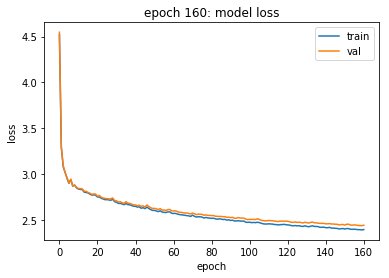

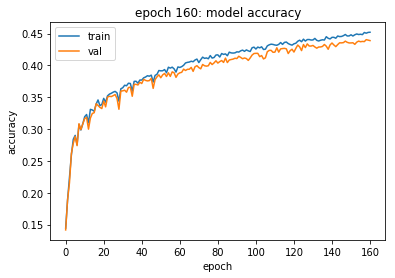



Epoch 161/500 ..............
Loss train:  2.392236525765525 
Loss val:  2.4373417147168843 
Train accuracy:  0.451025 
Validation accuracy:  0.4393
Alpha:  0.001


Epoch 162/500 ..............
Loss train:  2.3852997160729674 
Loss val:  2.433682150798103 
Train accuracy:  0.452475 
Validation accuracy:  0.4388
Alpha:  0.001


Epoch 163/500 ..............
Loss train:  2.383353045506289 
Loss val:  2.4314740458961976 
Train accuracy:  0.4523 
Validation accuracy:  0.4393
Alpha:  0.001


Epoch 164/500 ..............
Loss train:  2.390172630263675 
Loss val:  2.439715322670884 
Train accuracy:  0.45235 
Validation accuracy:  0.436
Alpha:  0.001


Epoch 165/500 ..............
Loss train:  2.383099894890946 
Loss val:  2.430106150095709 
Train accuracy:  0.452875 
Validation accuracy:  0.4418
Alpha:  0.001


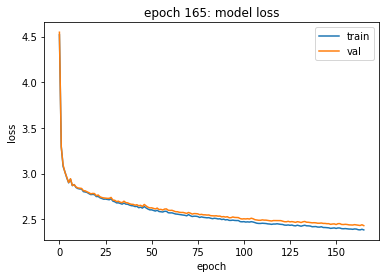

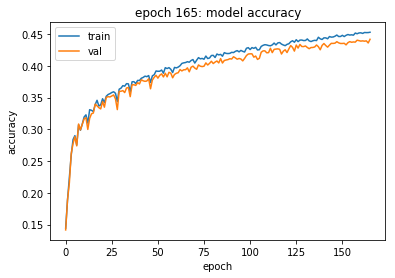



Epoch 166/500 ..............
Loss train:  2.3817857414359427 
Loss val:  2.431369878911879 
Train accuracy:  0.4562 
Validation accuracy:  0.4422
Alpha:  0.001


Epoch 167/500 ..............
Loss train:  2.3827330648838068 
Loss val:  2.4310160353473598 
Train accuracy:  0.45295 
Validation accuracy:  0.4423
Alpha:  0.001


Epoch 168/500 ..............
Loss train:  2.378978611486229 
Loss val:  2.427603809956263 
Train accuracy:  0.454275 
Validation accuracy:  0.4402
Alpha:  0.001


Epoch 169/500 ..............
Loss train:  2.3759336041989414 
Loss val:  2.4245161013618812 
Train accuracy:  0.454975 
Validation accuracy:  0.4423
Alpha:  0.001


Epoch 170/500 ..............
Loss train:  2.3752924470214363 
Loss val:  2.423664035430386 
Train accuracy:  0.4564 
Validation accuracy:  0.4439
Alpha:  0.001


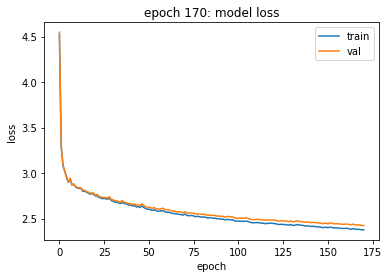

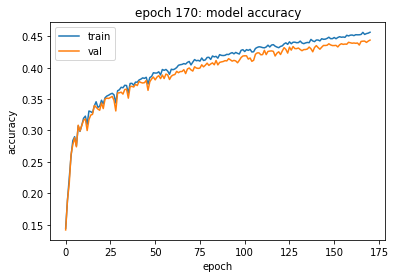



Epoch 171/500 ..............
Loss train:  2.376511344875865 
Loss val:  2.425369450529904 
Train accuracy:  0.4549 
Validation accuracy:  0.4408
Alpha:  0.001


Epoch 172/500 ..............
Loss train:  2.381110859967248 
Loss val:  2.431133367944718 
Train accuracy:  0.4536 
Validation accuracy:  0.4376
Alpha:  0.001


Epoch 173/500 ..............
Loss train:  2.373274647980654 
Loss val:  2.42314166902164 
Train accuracy:  0.4569 
Validation accuracy:  0.4413
Alpha:  0.001


Epoch 174/500 ..............
Loss train:  2.379699782558327 
Loss val:  2.4300968611207483 
Train accuracy:  0.453075 
Validation accuracy:  0.4376
Alpha:  0.001


Epoch 175/500 ..............
Loss train:  2.3752586661783615 
Loss val:  2.4272032188122035 
Train accuracy:  0.45675 
Validation accuracy:  0.4432
Alpha:  0.001


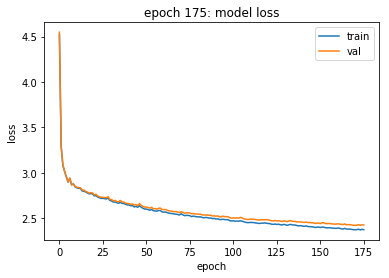

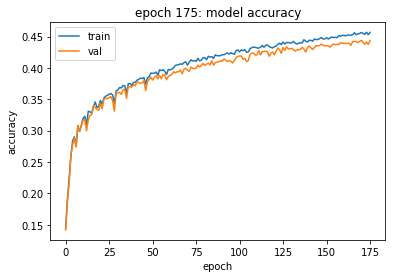



Epoch 176/500 ..............
Loss train:  2.3721078113542173 
Loss val:  2.422459268811081 
Train accuracy:  0.45455 
Validation accuracy:  0.4448
Alpha:  0.001


Epoch 177/500 ..............
Loss train:  2.370895582404062 
Loss val:  2.4224194573170155 
Train accuracy:  0.45665 
Validation accuracy:  0.4406
Alpha:  0.001


Epoch 178/500 ..............
Loss train:  2.370746508222505 
Loss val:  2.4243736289755313 
Train accuracy:  0.457025 
Validation accuracy:  0.4393
Alpha:  0.001


Epoch 179/500 ..............
Loss train:  2.363687132494454 
Loss val:  2.413694285515138 
Train accuracy:  0.45945 
Validation accuracy:  0.4443
Alpha:  0.001


Epoch 180/500 ..............
Loss train:  2.370424329057064 
Loss val:  2.4249270588832084 
Train accuracy:  0.454975 
Validation accuracy:  0.4384
Alpha:  0.001


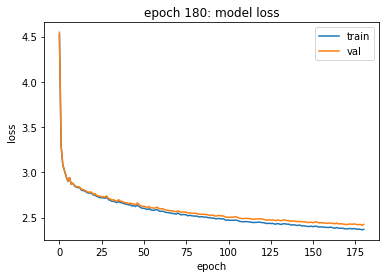

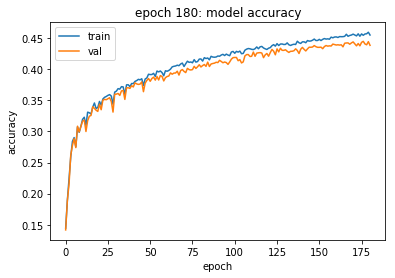



Epoch 181/500 ..............
Loss train:  2.377200271573483 
Loss val:  2.428318303401776 
Train accuracy:  0.452725 
Validation accuracy:  0.4355
Alpha:  0.001


Epoch 182/500 ..............
Loss train:  2.368103997347686 
Loss val:  2.4243739523946664 
Train accuracy:  0.45645 
Validation accuracy:  0.4405
Alpha:  0.001


Epoch 183/500 ..............
Loss train:  2.3677470489649832 
Loss val:  2.420543199539018 
Train accuracy:  0.458025 
Validation accuracy:  0.4451
Alpha:  0.001


Epoch 184/500 ..............
Loss train:  2.365937678135943 
Loss val:  2.4184288302494066 
Train accuracy:  0.4579 
Validation accuracy:  0.4459
Alpha:  0.001


Epoch 185/500 ..............
Loss train:  2.36524502222806 
Loss val:  2.418154440738329 
Train accuracy:  0.45695 
Validation accuracy:  0.4457
Alpha:  0.001


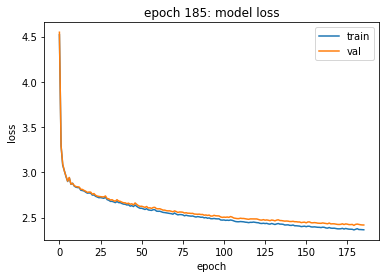

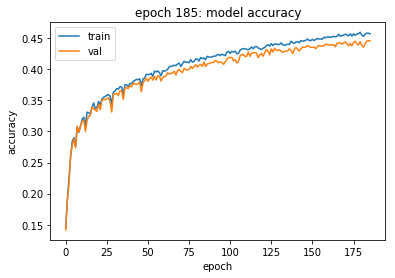



Epoch 186/500 ..............
Loss train:  2.3609208844330696 
Loss val:  2.4141949506766274 
Train accuracy:  0.4597 
Validation accuracy:  0.4434
Alpha:  0.001


Epoch 187/500 ..............
Loss train:  2.3660017288385737 
Loss val:  2.4173953103339545 
Train accuracy:  0.459825 
Validation accuracy:  0.4483
Alpha:  0.001


Epoch 188/500 ..............
Loss train:  2.3561988617918983 
Loss val:  2.410399340632799 
Train accuracy:  0.461075 
Validation accuracy:  0.4472
Alpha:  0.001


Epoch 189/500 ..............
Loss train:  2.3604629552363323 
Loss val:  2.4145642012463724 
Train accuracy:  0.45995 
Validation accuracy:  0.4426
Alpha:  0.001


Epoch 190/500 ..............
Loss train:  2.3597682042462713 
Loss val:  2.4131278352380536 
Train accuracy:  0.459825 
Validation accuracy:  0.4453
Alpha:  0.001


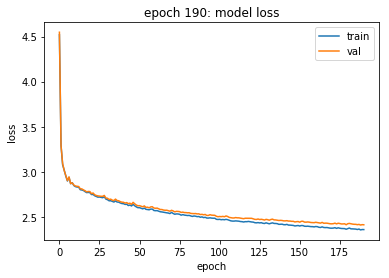

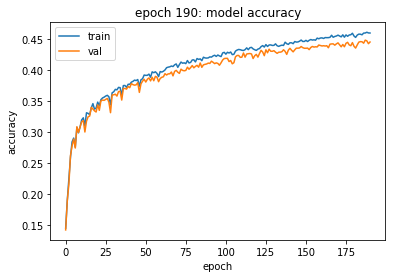



Epoch 191/500 ..............
Loss train:  2.36798865205858 
Loss val:  2.4216586864690255 
Train accuracy:  0.4555 
Validation accuracy:  0.4407
Alpha:  0.001


Epoch 192/500 ..............
Loss train:  2.3571024541202603 
Loss val:  2.412791360640698 
Train accuracy:  0.46105 
Validation accuracy:  0.4429
Alpha:  0.001


Epoch 193/500 ..............
Loss train:  2.358116272514658 
Loss val:  2.414602284068353 
Train accuracy:  0.46275 
Validation accuracy:  0.4464
Alpha:  0.001


Epoch 194/500 ..............
Loss train:  2.357483934061659 
Loss val:  2.4114640154640767 
Train accuracy:  0.46215 
Validation accuracy:  0.4509
Alpha:  0.001


Epoch 195/500 ..............
Loss train:  2.35684455218575 
Loss val:  2.4096846314520595 
Train accuracy:  0.4609 
Validation accuracy:  0.4473
Alpha:  0.001


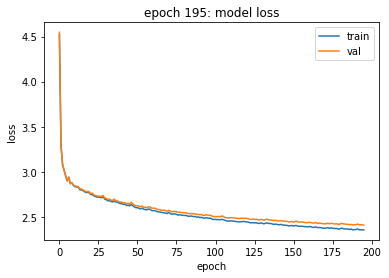

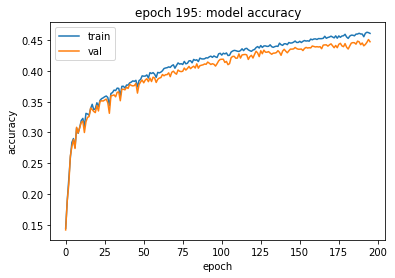



Epoch 196/500 ..............
Loss train:  2.350999206935104 
Loss val:  2.406060931796279 
Train accuracy:  0.4635 
Validation accuracy:  0.4495
Alpha:  0.001


Epoch 197/500 ..............
Loss train:  2.361354331411744 
Loss val:  2.4148730971238868 
Train accuracy:  0.4618 
Validation accuracy:  0.447
Alpha:  0.001


Epoch 198/500 ..............
Loss train:  2.347705352645614 
Loss val:  2.402169642910235 
Train accuracy:  0.46525 
Validation accuracy:  0.4493
Alpha:  0.001


Epoch 199/500 ..............
Loss train:  2.3526977551739363 
Loss val:  2.405787593656837 
Train accuracy:  0.459775 
Validation accuracy:  0.4451
Alpha:  0.001


Epoch 200/500 ..............
Loss train:  2.3469209727054094 
Loss val:  2.403509691443669 
Train accuracy:  0.4642 
Validation accuracy:  0.4485
Alpha:  0.001


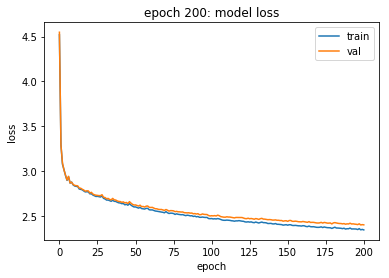

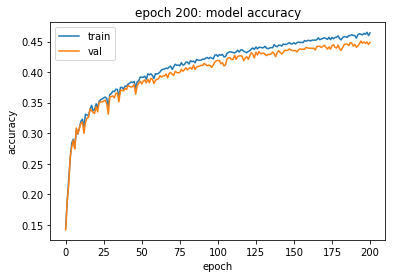



Epoch 201/500 ..............
Loss train:  2.3460462267959237 
Loss val:  2.400631932566257 
Train accuracy:  0.463325 
Validation accuracy:  0.4486
Alpha:  0.001


Epoch 202/500 ..............
Loss train:  2.3419657776930216 
Loss val:  2.399233239778072 
Train accuracy:  0.466025 
Validation accuracy:  0.4502
Alpha:  0.001


Epoch 203/500 ..............
Loss train:  2.340649334090088 
Loss val:  2.3968839961079813 
Train accuracy:  0.466925 
Validation accuracy:  0.4511
Alpha:  0.001


Epoch 204/500 ..............
Loss train:  2.343205391520907 
Loss val:  2.3983615878162317 
Train accuracy:  0.4655 
Validation accuracy:  0.4509
Alpha:  0.001


Epoch 205/500 ..............
Loss train:  2.3411971038560933 
Loss val:  2.397764162575284 
Train accuracy:  0.46735 
Validation accuracy:  0.451
Alpha:  0.001


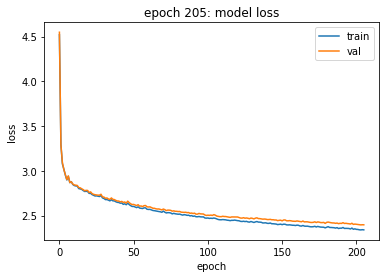

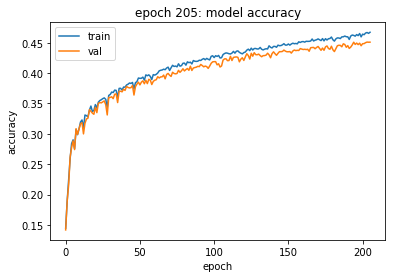



Epoch 206/500 ..............
Loss train:  2.340470736682992 
Loss val:  2.400224550458955 
Train accuracy:  0.466975 
Validation accuracy:  0.4482
Alpha:  0.001


Epoch 207/500 ..............
Loss train:  2.3401653012573393 
Loss val:  2.3967264596943885 
Train accuracy:  0.465025 
Validation accuracy:  0.4509
Alpha:  0.001


Epoch 208/500 ..............
Loss train:  2.3404889347347666 
Loss val:  2.3971615107295876 
Train accuracy:  0.46455 
Validation accuracy:  0.4492
Alpha:  0.001


Epoch 209/500 ..............
Loss train:  2.335657496590699 
Loss val:  2.393305566587626 
Train accuracy:  0.466125 
Validation accuracy:  0.4518
Alpha:  0.001


Epoch 210/500 ..............
Loss train:  2.338439054827817 
Loss val:  2.397814885673764 
Train accuracy:  0.466225 
Validation accuracy:  0.4503
Alpha:  0.001


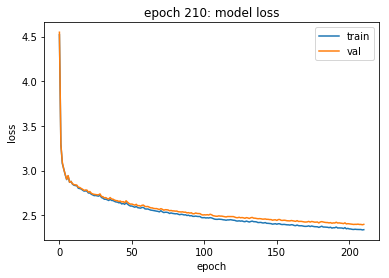

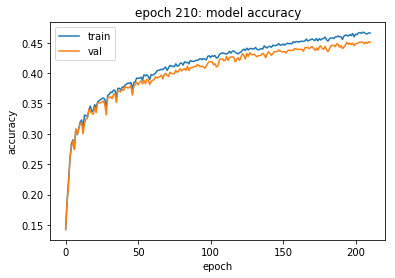



Epoch 211/500 ..............
Loss train:  2.338011162675283 
Loss val:  2.3982670818009173 
Train accuracy:  0.46875 
Validation accuracy:  0.4499
Alpha:  0.001


Epoch 212/500 ..............
Loss train:  2.3348901581060266 
Loss val:  2.392411642909639 
Train accuracy:  0.4672 
Validation accuracy:  0.4523
Alpha:  0.001


Epoch 213/500 ..............
Loss train:  2.3328501384823466 
Loss val:  2.3921898409038027 
Train accuracy:  0.467575 
Validation accuracy:  0.4515
Alpha:  0.001


Epoch 214/500 ..............
Loss train:  2.3346413441143246 
Loss val:  2.392809594001421 
Train accuracy:  0.468225 
Validation accuracy:  0.4532
Alpha:  0.001


Epoch 215/500 ..............
Loss train:  2.3395977787123563 
Loss val:  2.3992838807766774 
Train accuracy:  0.46715 
Validation accuracy:  0.4488
Alpha:  0.001


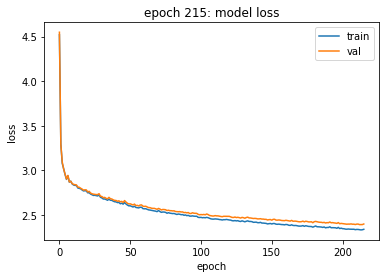

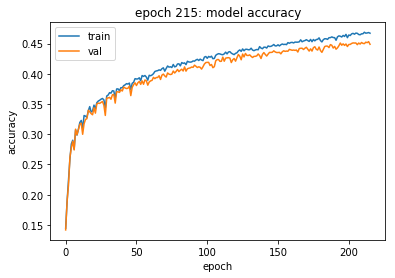



Epoch 216/500 ..............
Loss train:  2.3337614577104238 
Loss val:  2.391895627832419 
Train accuracy:  0.467775 
Validation accuracy:  0.4518
Alpha:  0.001


Epoch 217/500 ..............
Loss train:  2.3347472893992816 
Loss val:  2.395428573874125 
Train accuracy:  0.465225 
Validation accuracy:  0.4507
Alpha:  0.001


Epoch 218/500 ..............
Loss train:  2.3280371283194716 
Loss val:  2.3880732267507816 
Train accuracy:  0.469625 
Validation accuracy:  0.4535
Alpha:  0.001


Epoch 219/500 ..............
Loss train:  2.327183710963633 
Loss val:  2.38848669302334 
Train accuracy:  0.471025 
Validation accuracy:  0.4545
Alpha:  0.001


Epoch 220/500 ..............
Loss train:  2.3273291605206525 
Loss val:  2.3906840328746077 
Train accuracy:  0.47065 
Validation accuracy:  0.4537
Alpha:  0.001


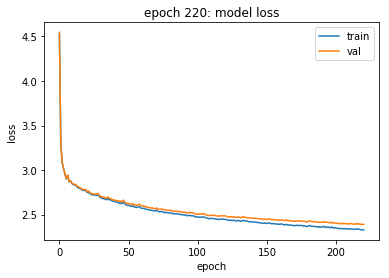

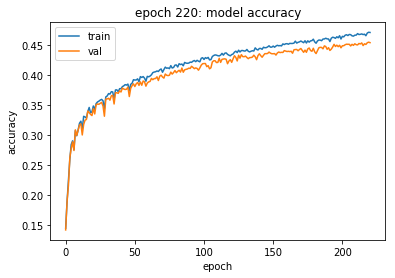



Epoch 221/500 ..............
Loss train:  2.3289735150726543 
Loss val:  2.391254586815489 
Train accuracy:  0.471525 
Validation accuracy:  0.4505
Alpha:  0.001


Epoch 222/500 ..............
Loss train:  2.326659141508339 
Loss val:  2.3857756297764188 
Train accuracy:  0.46845 
Validation accuracy:  0.4553
Alpha:  0.001


Epoch 223/500 ..............
Loss train:  2.3241754194675504 
Loss val:  2.386078243634113 
Train accuracy:  0.470525 
Validation accuracy:  0.4556
Alpha:  0.001


Epoch 224/500 ..............
Loss train:  2.3214463372752685 
Loss val:  2.3834905440242493 
Train accuracy:  0.470475 
Validation accuracy:  0.4543
Alpha:  0.001


Epoch 225/500 ..............
Loss train:  2.329129976198441 
Loss val:  2.3913230376502974 
Train accuracy:  0.4699 
Validation accuracy:  0.4518
Alpha:  0.001


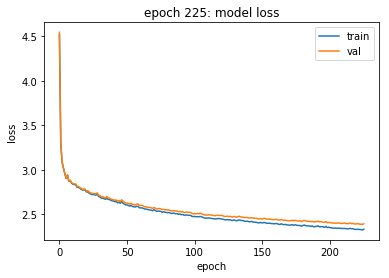

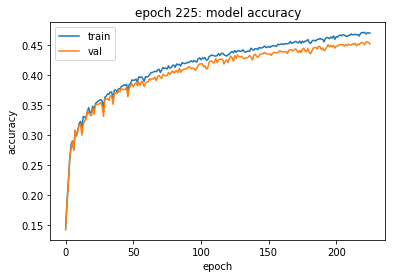



Epoch 226/500 ..............
Loss train:  2.331769934713287 
Loss val:  2.39339229009139 
Train accuracy:  0.470475 
Validation accuracy:  0.4531
Alpha:  0.001


Epoch 227/500 ..............
Loss train:  2.3312156803803767 
Loss val:  2.3940514713258465 
Train accuracy:  0.4709 
Validation accuracy:  0.4507
Alpha:  0.001


Epoch 228/500 ..............
Loss train:  2.3211778638377245 
Loss val:  2.38360089888682 
Train accuracy:  0.471775 
Validation accuracy:  0.4552
Alpha:  0.001


Epoch 229/500 ..............
Loss train:  2.32780953336464 
Loss val:  2.3908288840926155 
Train accuracy:  0.4712 
Validation accuracy:  0.4549
Alpha:  0.001


Epoch 230/500 ..............
Loss train:  2.3171485102187876 
Loss val:  2.379950496560686 
Train accuracy:  0.47365 
Validation accuracy:  0.4568
Alpha:  0.001


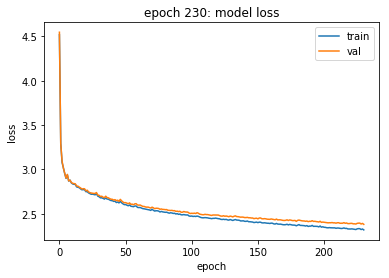

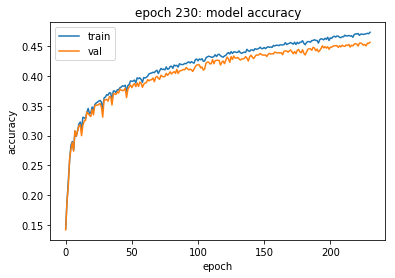



Epoch 231/500 ..............
Loss train:  2.321991679223793 
Loss val:  2.3852831694963723 
Train accuracy:  0.472575 
Validation accuracy:  0.4542
Alpha:  0.001


Epoch 232/500 ..............
Loss train:  2.318656820131013 
Loss val:  2.3803483274764696 
Train accuracy:  0.472375 
Validation accuracy:  0.4555
Alpha:  0.001


Epoch 233/500 ..............
Loss train:  2.320198607153469 
Loss val:  2.3834395587723294 
Train accuracy:  0.47155 
Validation accuracy:  0.4563
Alpha:  0.001


Epoch 234/500 ..............
Loss train:  2.320539521703071 
Loss val:  2.382856674153359 
Train accuracy:  0.470525 
Validation accuracy:  0.4545
Alpha:  0.001


Epoch 235/500 ..............
Loss train:  2.3163392836528436 
Loss val:  2.3814440510168233 
Train accuracy:  0.473675 
Validation accuracy:  0.4572
Alpha:  0.001


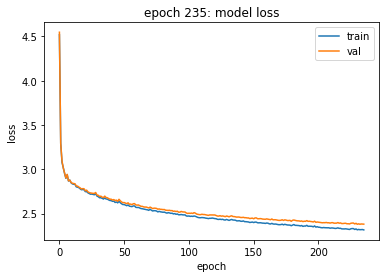

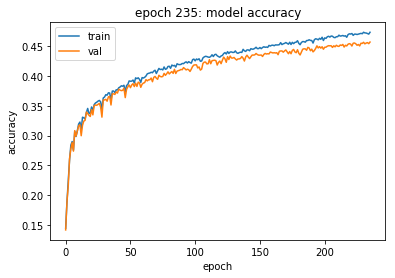



Epoch 236/500 ..............
Loss train:  2.3196129593782824 
Loss val:  2.3826109564444344 
Train accuracy:  0.4727 
Validation accuracy:  0.4569
Alpha:  0.001


Epoch 237/500 ..............
Loss train:  2.315666037544913 
Loss val:  2.381872468100342 
Train accuracy:  0.47525 
Validation accuracy:  0.4592
Alpha:  0.001


Epoch 238/500 ..............
Loss train:  2.318488575235825 
Loss val:  2.3831963902335627 
Train accuracy:  0.47155 
Validation accuracy:  0.4521
Alpha:  0.001


Epoch 239/500 ..............
Loss train:  2.3108119269118745 
Loss val:  2.3772554918343083 
Train accuracy:  0.476075 
Validation accuracy:  0.4569
Alpha:  0.001


Epoch 240/500 ..............
Loss train:  2.3126916377225903 
Loss val:  2.377655249580878 
Train accuracy:  0.4726 
Validation accuracy:  0.4553
Alpha:  0.001


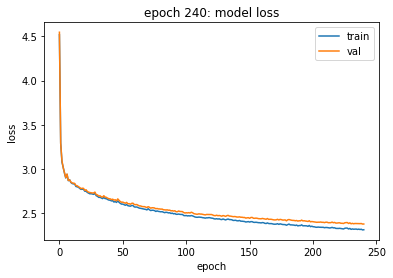

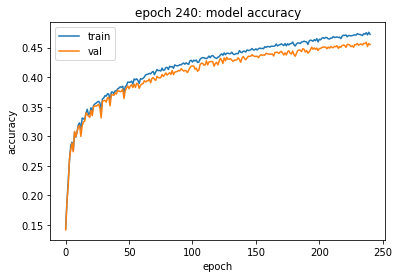



Epoch 241/500 ..............
Loss train:  2.3130878882200308 
Loss val:  2.3783279856904667 
Train accuracy:  0.4754 
Validation accuracy:  0.4573
Alpha:  0.001


Epoch 242/500 ..............
Loss train:  2.311364886783166 
Loss val:  2.3766221756676784 
Train accuracy:  0.47565 
Validation accuracy:  0.4565
Alpha:  0.001


Epoch 243/500 ..............
Loss train:  2.3083151547327483 
Loss val:  2.372747076188431 
Train accuracy:  0.475625 
Validation accuracy:  0.4583
Alpha:  0.001


Epoch 244/500 ..............
Loss train:  2.308313176677726 
Loss val:  2.372610599024295 
Train accuracy:  0.476125 
Validation accuracy:  0.4579
Alpha:  0.001


Epoch 245/500 ..............
Loss train:  2.311183586673211 
Loss val:  2.3784917027758596 
Train accuracy:  0.475425 
Validation accuracy:  0.4567
Alpha:  0.001


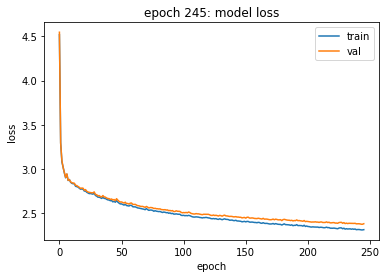

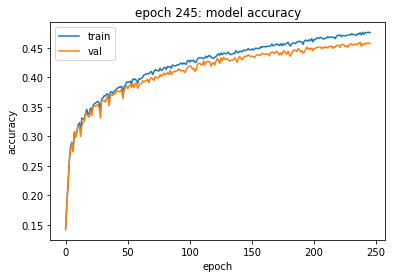



Epoch 246/500 ..............
Loss train:  2.309449531051621 
Loss val:  2.376369031008516 
Train accuracy:  0.4745 
Validation accuracy:  0.4583
Alpha:  0.001


Epoch 247/500 ..............
Loss train:  2.3063077467158974 
Loss val:  2.3727022649358256 
Train accuracy:  0.477175 
Validation accuracy:  0.4581
Alpha:  0.001


Epoch 248/500 ..............
Loss train:  2.311912622752326 
Loss val:  2.378261818367271 
Train accuracy:  0.47705 
Validation accuracy:  0.4594
Alpha:  0.001


Epoch 249/500 ..............
Loss train:  2.3104041659787535 
Loss val:  2.375764870685735 
Train accuracy:  0.476075 
Validation accuracy:  0.4598
Alpha:  0.001


Epoch 250/500 ..............
Loss train:  2.301789939851143 
Loss val:  2.3682025171741583 
Train accuracy:  0.476925 
Validation accuracy:  0.4568
Alpha:  0.001


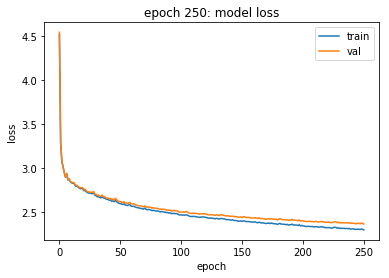

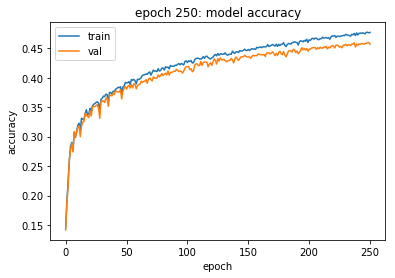



Epoch 251/500 ..............
Loss train:  2.3133408096204535 
Loss val:  2.3838181996674686 
Train accuracy:  0.47365 
Validation accuracy:  0.4534
Alpha:  0.001


Epoch 252/500 ..............
Loss train:  2.304495217759265 
Loss val:  2.375687260995017 
Train accuracy:  0.477425 
Validation accuracy:  0.4534
Alpha:  0.001


Epoch 253/500 ..............
Loss train:  2.3074887598321316 
Loss val:  2.373272207576897 
Train accuracy:  0.4751 
Validation accuracy:  0.4601
Alpha:  0.001


Epoch 254/500 ..............
Loss train:  2.3036739798643713 
Loss val:  2.3727470346514665 
Train accuracy:  0.478 
Validation accuracy:  0.4581
Alpha:  0.001


Epoch 255/500 ..............
Loss train:  2.3011550223932273 
Loss val:  2.3692897011115552 
Train accuracy:  0.478625 
Validation accuracy:  0.4596
Alpha:  0.001


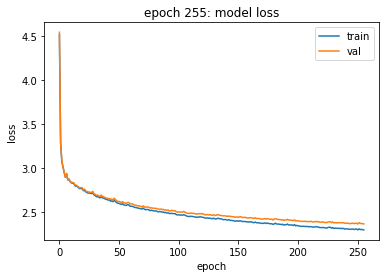

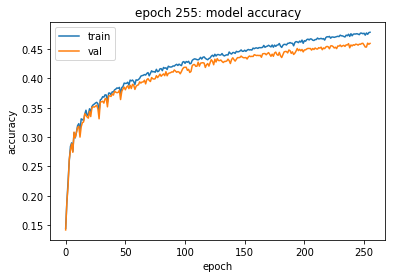



Epoch 256/500 ..............
Loss train:  2.2981350316127833 
Loss val:  2.3666232999948784 
Train accuracy:  0.4786 
Validation accuracy:  0.4576
Alpha:  0.001


Epoch 257/500 ..............
Loss train:  2.2980511448365832 
Loss val:  2.3667117531456414 
Train accuracy:  0.479625 
Validation accuracy:  0.4612
Alpha:  0.001


Epoch 258/500 ..............
Loss train:  2.302083200434014 
Loss val:  2.371650847412 
Train accuracy:  0.478575 
Validation accuracy:  0.4591
Alpha:  0.001


Epoch 259/500 ..............
Loss train:  2.306095595153989 
Loss val:  2.3767547101379107 
Train accuracy:  0.475925 
Validation accuracy:  0.4556
Alpha:  0.001


Epoch 260/500 ..............
Loss train:  2.2975285783684334 
Loss val:  2.3647786971675853 
Train accuracy:  0.477425 
Validation accuracy:  0.4637
Alpha:  0.001


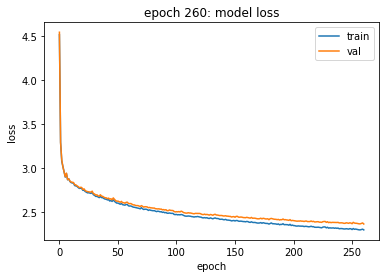

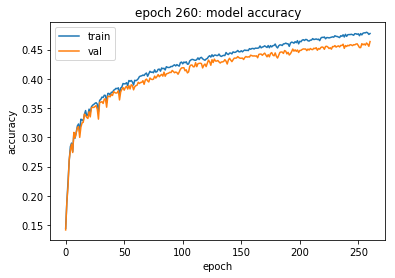



Epoch 261/500 ..............
Loss train:  2.2929815660369632 
Loss val:  2.361768272570844 
Train accuracy:  0.480575 
Validation accuracy:  0.4612
Alpha:  0.001


Epoch 262/500 ..............
Loss train:  2.2934204956738538 
Loss val:  2.362116542429233 
Train accuracy:  0.479775 
Validation accuracy:  0.4611
Alpha:  0.001


Epoch 263/500 ..............
Loss train:  2.2956833321655252 
Loss val:  2.3659302453357474 
Train accuracy:  0.478625 
Validation accuracy:  0.4585
Alpha:  0.001


Epoch 264/500 ..............
Loss train:  2.2904554722543753 
Loss val:  2.361208105250608 
Train accuracy:  0.481525 
Validation accuracy:  0.4613
Alpha:  0.001


Epoch 265/500 ..............
Loss train:  2.2975509938685814 
Loss val:  2.367834329666186 
Train accuracy:  0.480175 
Validation accuracy:  0.4591
Alpha:  0.001


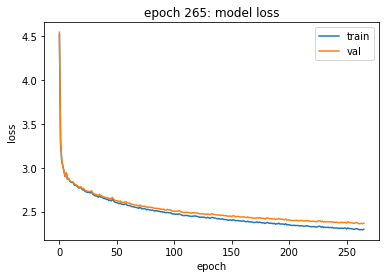

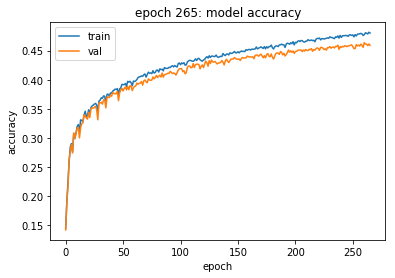



Epoch 266/500 ..............
Loss train:  2.2899079934310036 
Loss val:  2.360223058621998 
Train accuracy:  0.481975 
Validation accuracy:  0.4624
Alpha:  0.001


Epoch 267/500 ..............
Loss train:  2.288858908921542 
Loss val:  2.359569347018649 
Train accuracy:  0.48185 
Validation accuracy:  0.4603
Alpha:  0.001


Epoch 268/500 ..............
Loss train:  2.2940879622759804 
Loss val:  2.366022550693711 
Train accuracy:  0.480075 
Validation accuracy:  0.4571
Alpha:  0.001


Epoch 269/500 ..............
Loss train:  2.291462359584922 
Loss val:  2.3607976616612434 
Train accuracy:  0.47895 
Validation accuracy:  0.4627
Alpha:  0.001


Epoch 270/500 ..............
Loss train:  2.291907513473277 
Loss val:  2.364908588911459 
Train accuracy:  0.481325 
Validation accuracy:  0.4582
Alpha:  0.001


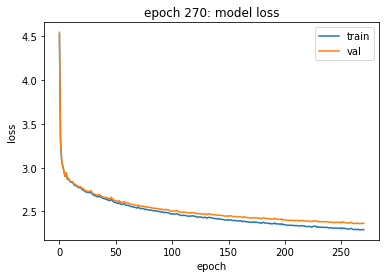

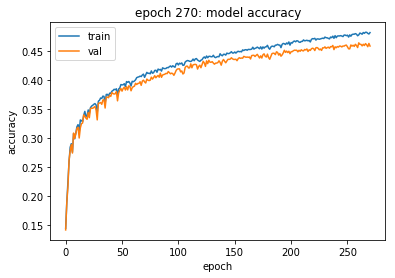



Epoch 271/500 ..............
Loss train:  2.2887882179219807 
Loss val:  2.3590181668237786 
Train accuracy:  0.48085 
Validation accuracy:  0.463
Alpha:  0.001


Epoch 272/500 ..............
Loss train:  2.2902634349375175 
Loss val:  2.360949206286648 
Train accuracy:  0.48165 
Validation accuracy:  0.4616
Alpha:  0.001


Epoch 273/500 ..............
Loss train:  2.29050967470135 
Loss val:  2.362468292924223 
Train accuracy:  0.481175 
Validation accuracy:  0.4593
Alpha:  0.001


Epoch 274/500 ..............
Loss train:  2.285575897975624 
Loss val:  2.3582278188390333 
Train accuracy:  0.48135 
Validation accuracy:  0.4588
Alpha:  0.001


Epoch 275/500 ..............
Loss train:  2.289307615841454 
Loss val:  2.364126701537404 
Train accuracy:  0.48125 
Validation accuracy:  0.4593
Alpha:  0.001


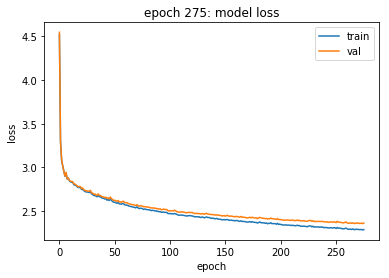

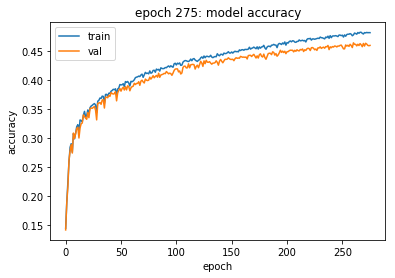



Epoch 276/500 ..............
Loss train:  2.285122382512514 
Loss val:  2.3602369348451675 
Train accuracy:  0.482675 
Validation accuracy:  0.4589
Alpha:  0.001


Epoch 277/500 ..............
Loss train:  2.2828825668856894 
Loss val:  2.355396060864465 
Train accuracy:  0.483775 
Validation accuracy:  0.4632
Alpha:  0.001


Epoch 278/500 ..............
Loss train:  2.2813938279870936 
Loss val:  2.354445738857093 
Train accuracy:  0.4848 
Validation accuracy:  0.4632
Alpha:  0.001


Epoch 279/500 ..............
Loss train:  2.2829210996045326 
Loss val:  2.3572254201303964 
Train accuracy:  0.48275 
Validation accuracy:  0.4584
Alpha:  0.001


Epoch 280/500 ..............
Loss train:  2.2820921741163787 
Loss val:  2.3569025611748113 
Train accuracy:  0.483625 
Validation accuracy:  0.4624
Alpha:  0.001


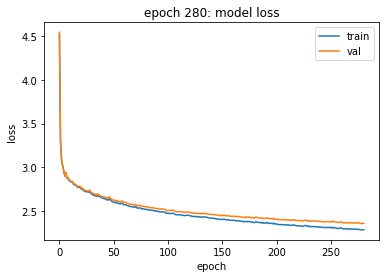

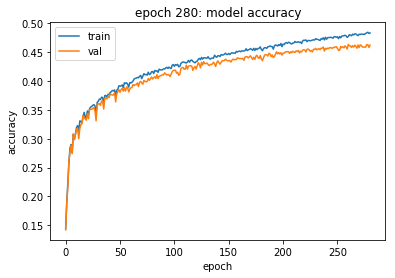



Epoch 281/500 ..............
Loss train:  2.2852879141503943 
Loss val:  2.358930082284293 
Train accuracy:  0.483325 
Validation accuracy:  0.464
Alpha:  0.001


Epoch 282/500 ..............
Loss train:  2.2847788040004158 
Loss val:  2.3617940708461793 
Train accuracy:  0.48135 
Validation accuracy:  0.4565
Alpha:  0.001


Epoch 283/500 ..............
Loss train:  2.281563417336558 
Loss val:  2.35557718862123 
Train accuracy:  0.48245 
Validation accuracy:  0.4599
Alpha:  0.001


Epoch 284/500 ..............
Loss train:  2.2785032015327085 
Loss val:  2.3525944939073855 
Train accuracy:  0.48315 
Validation accuracy:  0.4618
Alpha:  0.001


Epoch 285/500 ..............
Loss train:  2.2792810331192728 
Loss val:  2.3520998824150214 
Train accuracy:  0.484525 
Validation accuracy:  0.4641
Alpha:  0.001


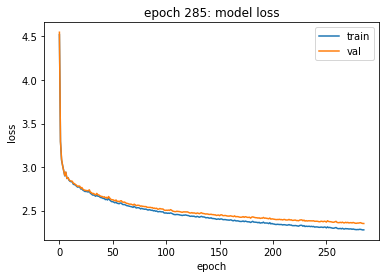

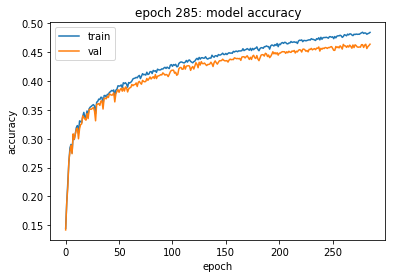



Epoch 286/500 ..............
Loss train:  2.276942899966669 
Loss val:  2.3513915251267505 
Train accuracy:  0.48555 
Validation accuracy:  0.4627
Alpha:  0.001


Epoch 287/500 ..............
Loss train:  2.2792055856971434 
Loss val:  2.3529767554808676 
Train accuracy:  0.4829 
Validation accuracy:  0.4628
Alpha:  0.001


Epoch 288/500 ..............
Loss train:  2.273083223700927 
Loss val:  2.3472689047430535 
Train accuracy:  0.4855 
Validation accuracy:  0.4654
Alpha:  0.001


Epoch 289/500 ..............
Loss train:  2.279079752065393 
Loss val:  2.351753953871408 
Train accuracy:  0.48365 
Validation accuracy:  0.465
Alpha:  0.001


Epoch 290/500 ..............
Loss train:  2.2754849348957387 
Loss val:  2.35035393724571 
Train accuracy:  0.48365 
Validation accuracy:  0.4639
Alpha:  0.001


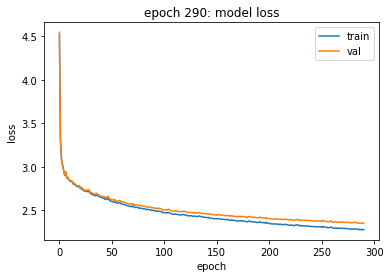

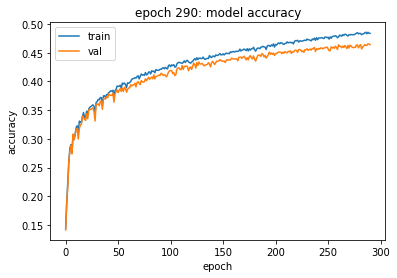



Epoch 291/500 ..............
Loss train:  2.282548090444837 
Loss val:  2.3563238191495612 
Train accuracy:  0.482675 
Validation accuracy:  0.4639
Alpha:  0.001


Epoch 292/500 ..............
Loss train:  2.287978122746456 
Loss val:  2.3600036624259175 
Train accuracy:  0.481875 
Validation accuracy:  0.4628
Alpha:  0.001


Epoch 293/500 ..............
Loss train:  2.274862432658707 
Loss val:  2.3504538630765395 
Train accuracy:  0.486775 
Validation accuracy:  0.4675
Alpha:  0.001


Epoch 294/500 ..............
Loss train:  2.281542369657873 
Loss val:  2.3565881365194175 
Train accuracy:  0.483375 
Validation accuracy:  0.4638
Alpha:  0.001


Epoch 295/500 ..............
Loss train:  2.271898545374278 
Loss val:  2.347472196961713 
Train accuracy:  0.485575 
Validation accuracy:  0.4674
Alpha:  0.001


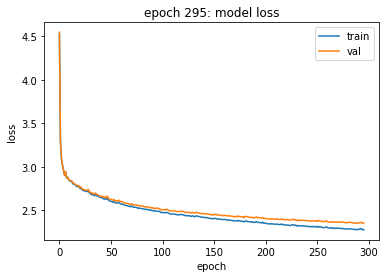

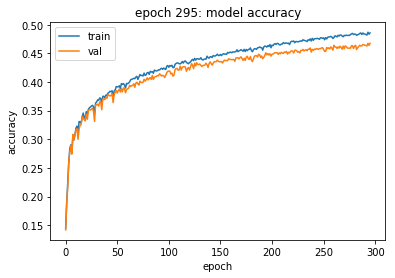



Epoch 296/500 ..............
Loss train:  2.2736091865478456 
Loss val:  2.351560685662586 
Train accuracy:  0.486825 
Validation accuracy:  0.4626
Alpha:  0.001


Epoch 297/500 ..............
Loss train:  2.272517753403272 
Loss val:  2.3471474914645887 
Train accuracy:  0.4852 
Validation accuracy:  0.4658
Alpha:  0.001


Epoch 298/500 ..............
Loss train:  2.273958624690378 
Loss val:  2.350930808348082 
Train accuracy:  0.48475 
Validation accuracy:  0.4651
Alpha:  0.001


Epoch 299/500 ..............
Loss train:  2.271938157414426 
Loss val:  2.3510241696614407 
Train accuracy:  0.48645 
Validation accuracy:  0.4625
Alpha:  0.001


Epoch 300/500 ..............
Loss train:  2.2785197836887696 
Loss val:  2.3579400009220217 
Train accuracy:  0.48255 
Validation accuracy:  0.4573
Alpha:  0.001


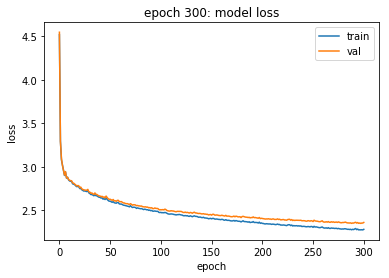

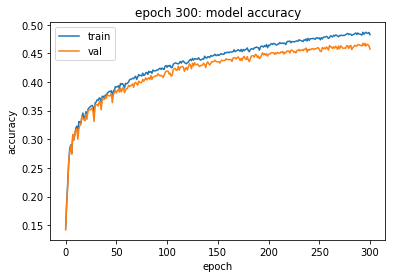



Epoch 301/500 ..............
Loss train:  2.2687994817342396 
Loss val:  2.3454000901710668 
Train accuracy:  0.485725 
Validation accuracy:  0.465
Alpha:  0.001


Epoch 302/500 ..............
Loss train:  2.267927347996116 
Loss val:  2.3437533658801013 
Train accuracy:  0.487025 
Validation accuracy:  0.4649
Alpha:  0.001


Epoch 303/500 ..............
Loss train:  2.267675730088562 
Loss val:  2.344662885915672 
Train accuracy:  0.4866 
Validation accuracy:  0.4654
Alpha:  0.001


Epoch 304/500 ..............
Loss train:  2.269688392110345 
Loss val:  2.3471964582635985 
Train accuracy:  0.485475 
Validation accuracy:  0.4633
Alpha:  0.001


Epoch 305/500 ..............
Loss train:  2.2672901982259503 
Loss val:  2.3467725124376875 
Train accuracy:  0.48765 
Validation accuracy:  0.4586
Alpha:  0.001


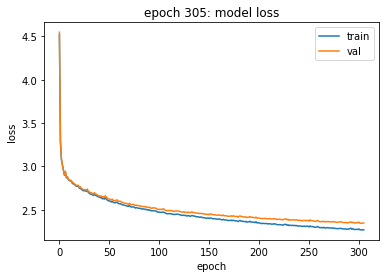

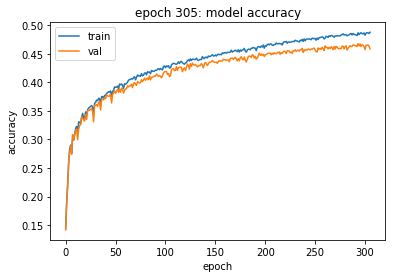



Epoch 306/500 ..............
Loss train:  2.2657817861360305 
Loss val:  2.3433166404582972 
Train accuracy:  0.48635 
Validation accuracy:  0.4626
Alpha:  0.001


Epoch 307/500 ..............
Loss train:  2.267815367382825 
Loss val:  2.3476551225156115 
Train accuracy:  0.487825 
Validation accuracy:  0.4629
Alpha:  0.001


Epoch 308/500 ..............
Loss train:  2.26733347835885 
Loss val:  2.342745307058052 
Train accuracy:  0.484775 
Validation accuracy:  0.4657
Alpha:  0.001


Epoch 309/500 ..............
Loss train:  2.263838634120467 
Loss val:  2.3435746076513477 
Train accuracy:  0.48765 
Validation accuracy:  0.4657
Alpha:  0.001


Epoch 310/500 ..............
Loss train:  2.2692935130873493 
Loss val:  2.347726039274383 
Train accuracy:  0.4854 
Validation accuracy:  0.4656
Alpha:  0.001


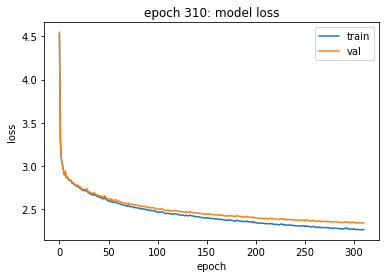

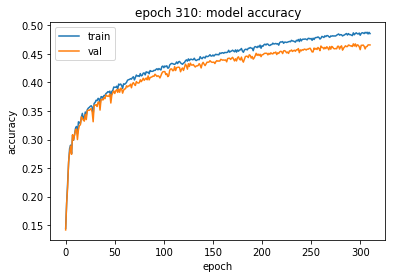



Epoch 311/500 ..............
Loss train:  2.266306895505453 
Loss val:  2.3446246772544543 
Train accuracy:  0.486375 
Validation accuracy:  0.4667
Alpha:  0.001


Epoch 312/500 ..............
Loss train:  2.2696999612384183 
Loss val:  2.349201190233516 
Train accuracy:  0.484925 
Validation accuracy:  0.463
Alpha:  0.001


Epoch 313/500 ..............
Loss train:  2.2701682304476583 
Loss val:  2.3508841409369188 
Train accuracy:  0.486375 
Validation accuracy:  0.4637
Alpha:  0.001


Epoch 314/500 ..............
Loss train:  2.264478359467268 
Loss val:  2.345633191952786 
Train accuracy:  0.4869 
Validation accuracy:  0.462
Alpha:  0.001


Epoch 315/500 ..............
Loss train:  2.262254267443343 
Loss val:  2.341430387451703 
Train accuracy:  0.489625 
Validation accuracy:  0.4678
Alpha:  0.001


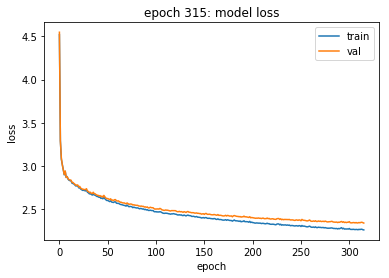

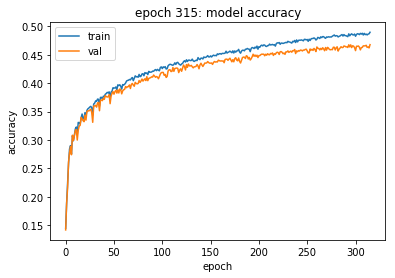



Epoch 316/500 ..............
Loss train:  2.265072617117846 
Loss val:  2.3455712195366263 
Train accuracy:  0.487525 
Validation accuracy:  0.4652
Alpha:  0.001


Epoch 317/500 ..............
Loss train:  2.2603185890759807 
Loss val:  2.3409606985339333 
Train accuracy:  0.48995 
Validation accuracy:  0.467
Alpha:  0.001


Epoch 318/500 ..............
Loss train:  2.2545082455522936 
Loss val:  2.336243245836602 
Train accuracy:  0.4911 
Validation accuracy:  0.4667
Alpha:  0.001


Epoch 319/500 ..............
Loss train:  2.2577567096375475 
Loss val:  2.3390436402940167 
Train accuracy:  0.490525 
Validation accuracy:  0.4663
Alpha:  0.001


Epoch 320/500 ..............
Loss train:  2.263253939658077 
Loss val:  2.3422769939797368 
Train accuracy:  0.488575 
Validation accuracy:  0.4662
Alpha:  0.001


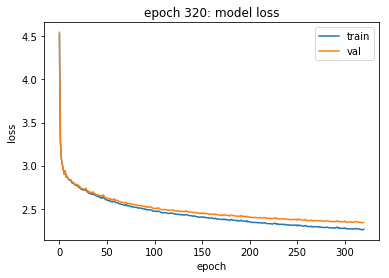

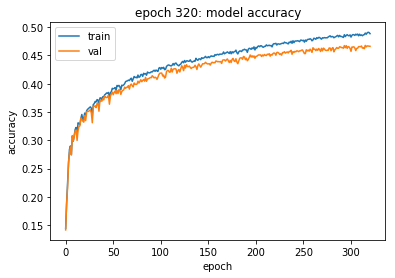



Epoch 321/500 ..............
Loss train:  2.2523645950954263 
Loss val:  2.3322769159530523 
Train accuracy:  0.4916 
Validation accuracy:  0.4712
Alpha:  0.001


Epoch 322/500 ..............
Loss train:  2.259395599746764 
Loss val:  2.3396132422591376 
Train accuracy:  0.48705 
Validation accuracy:  0.4696
Alpha:  0.001


Epoch 323/500 ..............
Loss train:  2.257078435142198 
Loss val:  2.3367635686281116 
Train accuracy:  0.489425 
Validation accuracy:  0.4677
Alpha:  0.001


Epoch 324/500 ..............
Loss train:  2.254552256411322 
Loss val:  2.3351704482054165 
Train accuracy:  0.491275 
Validation accuracy:  0.4693
Alpha:  0.001


Epoch 325/500 ..............
Loss train:  2.252212718268887 
Loss val:  2.3335967874026364 
Train accuracy:  0.491525 
Validation accuracy:  0.4697
Alpha:  0.001


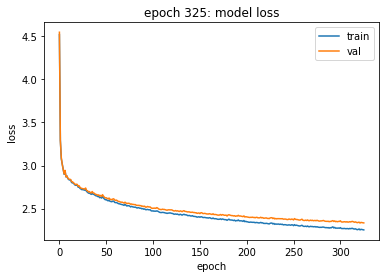

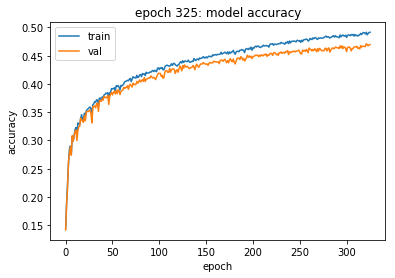



Epoch 326/500 ..............
Loss train:  2.2512623559487706 
Loss val:  2.332285528134021 
Train accuracy:  0.492275 
Validation accuracy:  0.4693
Alpha:  0.001


Epoch 327/500 ..............
Loss train:  2.254197274160004 
Loss val:  2.3377432191670326 
Train accuracy:  0.49205 
Validation accuracy:  0.4669
Alpha:  0.001


Epoch 328/500 ..............
Loss train:  2.252248862239169 
Loss val:  2.3356054533857407 
Train accuracy:  0.492075 
Validation accuracy:  0.4708
Alpha:  0.001


Epoch 329/500 ..............
Loss train:  2.2546198732732323 
Loss val:  2.3363589282909563 
Train accuracy:  0.489525 
Validation accuracy:  0.4661
Alpha:  0.001


Epoch 330/500 ..............
Loss train:  2.2478431024683343 
Loss val:  2.3305283543788966 
Train accuracy:  0.491925 
Validation accuracy:  0.4692
Alpha:  0.001


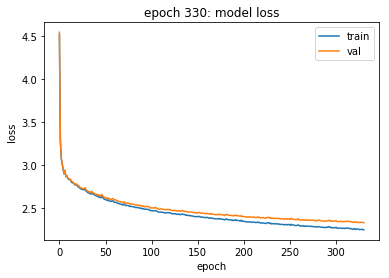

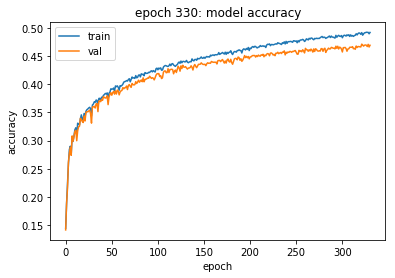



Epoch 331/500 ..............
Loss train:  2.2467673107123702 
Loss val:  2.3292537099452906 
Train accuracy:  0.49175 
Validation accuracy:  0.472
Alpha:  0.001


Epoch 332/500 ..............
Loss train:  2.2487933756383898 
Loss val:  2.3336960100252266 
Train accuracy:  0.490525 
Validation accuracy:  0.4654
Alpha:  0.001


Epoch 333/500 ..............
Loss train:  2.255989605904769 
Loss val:  2.3414099143379006 
Train accuracy:  0.491825 
Validation accuracy:  0.4636
Alpha:  0.001


Epoch 334/500 ..............
Loss train:  2.2467896760617783 
Loss val:  2.3321159658617083 
Train accuracy:  0.491375 
Validation accuracy:  0.4668
Alpha:  0.001


Epoch 335/500 ..............
Loss train:  2.250271760137611 
Loss val:  2.338164403966993 
Train accuracy:  0.492475 
Validation accuracy:  0.4666
Alpha:  0.001


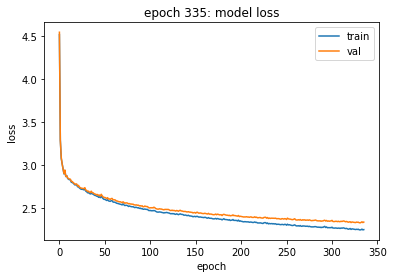

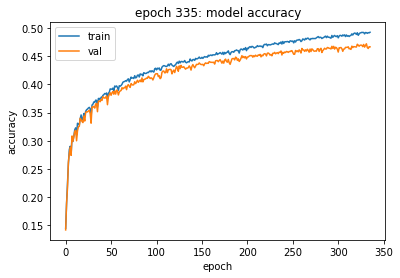



Epoch 336/500 ..............
Loss train:  2.2541188371486087 
Loss val:  2.3425238437162093 
Train accuracy:  0.48825 
Validation accuracy:  0.4623
Alpha:  0.001


Epoch 337/500 ..............
Loss train:  2.246640210534249 
Loss val:  2.3309006735169397 
Train accuracy:  0.491075 
Validation accuracy:  0.4685
Alpha:  0.001


Epoch 338/500 ..............
Loss train:  2.2450922139883196 
Loss val:  2.3309166855212036 
Train accuracy:  0.491925 
Validation accuracy:  0.467
Alpha:  0.001


Epoch 339/500 ..............
Loss train:  2.2535637978534204 
Loss val:  2.33707538708339 
Train accuracy:  0.491225 
Validation accuracy:  0.4658
Alpha:  0.001


Epoch 340/500 ..............
Loss train:  2.243306252086915 
Loss val:  2.3284101468193015 
Train accuracy:  0.493775 
Validation accuracy:  0.4692
Alpha:  0.001


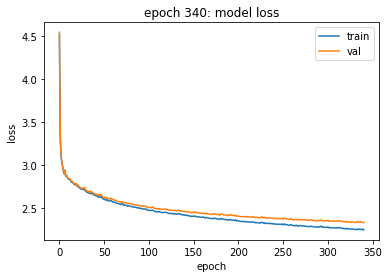

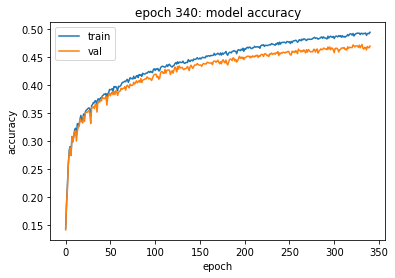



Epoch 341/500 ..............
Loss train:  2.2422217189562654 
Loss val:  2.3274998958694635 
Train accuracy:  0.49355 
Validation accuracy:  0.4687
Alpha:  0.001


Epoch 342/500 ..............
Loss train:  2.245935447664704 
Loss val:  2.3327690192705863 
Train accuracy:  0.490775 
Validation accuracy:  0.4681
Alpha:  0.001


Epoch 343/500 ..............
Loss train:  2.2409527826800226 
Loss val:  2.3260729685164128 
Train accuracy:  0.4938 
Validation accuracy:  0.47
Alpha:  0.001


Epoch 344/500 ..............
Loss train:  2.2428058323832047 
Loss val:  2.3283818904131035 
Train accuracy:  0.49295 
Validation accuracy:  0.4697
Alpha:  0.001


Epoch 345/500 ..............
Loss train:  2.242847581491729 
Loss val:  2.327072896888556 
Train accuracy:  0.493775 
Validation accuracy:  0.4712
Alpha:  0.001


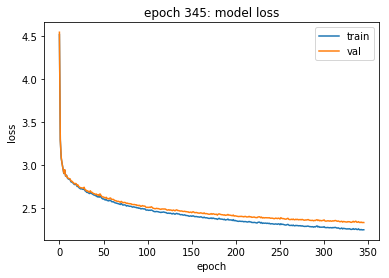

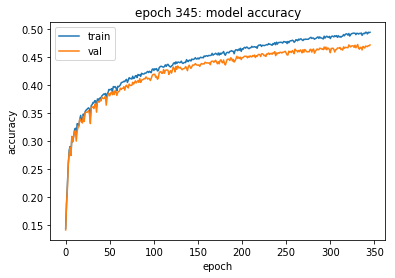



Epoch 346/500 ..............
Loss train:  2.2449340292979074 
Loss val:  2.330929028726038 
Train accuracy:  0.492325 
Validation accuracy:  0.4686
Alpha:  0.001


Epoch 347/500 ..............
Loss train:  2.23922177704248 
Loss val:  2.326041450687726 
Train accuracy:  0.49535 
Validation accuracy:  0.4691
Alpha:  0.001


Epoch 348/500 ..............
Loss train:  2.2399757253132435 
Loss val:  2.3261380066424184 
Train accuracy:  0.49565 
Validation accuracy:  0.4722
Alpha:  0.001


Epoch 349/500 ..............
Loss train:  2.2354988162800793 
Loss val:  2.3221703758764156 
Train accuracy:  0.49485 
Validation accuracy:  0.474
Alpha:  0.001


Epoch 350/500 ..............
Loss train:  2.2388961607657287 
Loss val:  2.3262747731749363 
Train accuracy:  0.494125 
Validation accuracy:  0.4692
Alpha:  0.001


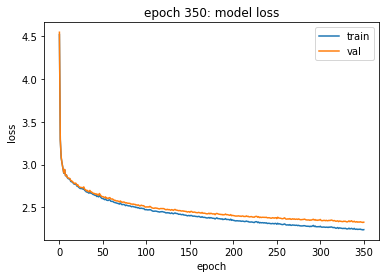

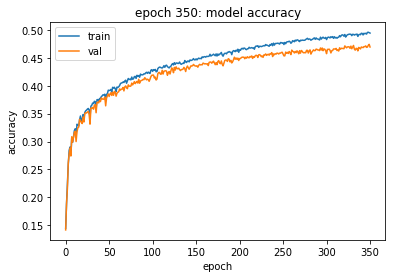



Epoch 351/500 ..............
Loss train:  2.2400239529756494 
Loss val:  2.325217521948303 
Train accuracy:  0.4946 
Validation accuracy:  0.474
Alpha:  0.001


Epoch 352/500 ..............
Loss train:  2.243826046303762 
Loss val:  2.3297913331614133 
Train accuracy:  0.493175 
Validation accuracy:  0.4687
Alpha:  0.001


Epoch 353/500 ..............
Loss train:  2.239894955008058 
Loss val:  2.3275491811665847 
Train accuracy:  0.49345 
Validation accuracy:  0.4693
Alpha:  0.001


Epoch 354/500 ..............
Loss train:  2.242210748854026 
Loss val:  2.3289885651697118 
Train accuracy:  0.49605 
Validation accuracy:  0.4718
Alpha:  0.001


Epoch 355/500 ..............
Loss train:  2.2427255243460475 
Loss val:  2.3331292425346533 
Train accuracy:  0.49225 
Validation accuracy:  0.4671
Alpha:  0.001


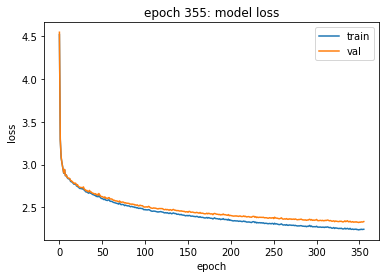

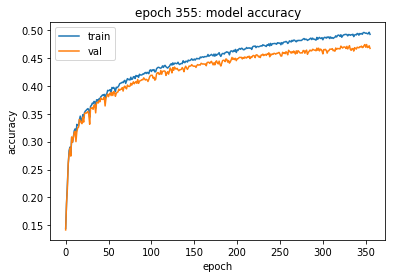



Epoch 356/500 ..............
Loss train:  2.2382067980237514 
Loss val:  2.328059479426779 
Train accuracy:  0.494275 
Validation accuracy:  0.4703
Alpha:  0.001


Epoch 357/500 ..............
Loss train:  2.2451166012706505 
Loss val:  2.3354393840209817 
Train accuracy:  0.493925 
Validation accuracy:  0.4706
Alpha:  0.001


Epoch 358/500 ..............
Loss train:  2.2379787717207855 
Loss val:  2.326745867924381 
Train accuracy:  0.494975 
Validation accuracy:  0.4727
Alpha:  0.001


Epoch 359/500 ..............
Loss train:  2.23886421365117 
Loss val:  2.330234369721838 
Train accuracy:  0.494475 
Validation accuracy:  0.4664
Alpha:  0.001


Epoch 360/500 ..............
Loss train:  2.2326377837968563 
Loss val:  2.323806875368558 
Train accuracy:  0.4983 
Validation accuracy:  0.4722
Alpha:  0.001


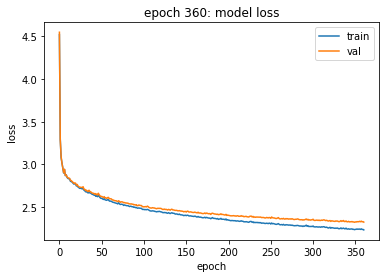

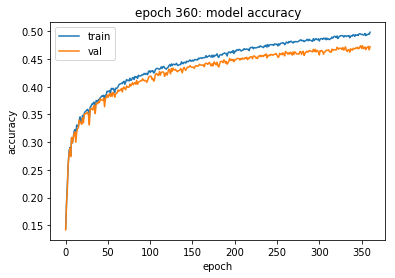



Epoch 361/500 ..............
Loss train:  2.2318872973212165 
Loss val:  2.3231611669197108 
Train accuracy:  0.4976 
Validation accuracy:  0.4734
Alpha:  0.001


Epoch 362/500 ..............
Loss train:  2.236065322413343 
Loss val:  2.3248663226512516 
Train accuracy:  0.496 
Validation accuracy:  0.4723
Alpha:  0.001


Epoch 363/500 ..............
Loss train:  2.2373267705225475 
Loss val:  2.329772399336973 
Train accuracy:  0.4955 
Validation accuracy:  0.4663
Alpha:  0.001


Epoch 364/500 ..............
Loss train:  2.2288213114901207 
Loss val:  2.320635384416559 
Train accuracy:  0.4985 
Validation accuracy:  0.4723
Alpha:  0.001


Epoch 365/500 ..............
Loss train:  2.2384041405719106 
Loss val:  2.3299607811787584 
Train accuracy:  0.496575 
Validation accuracy:  0.4706
Alpha:  0.001


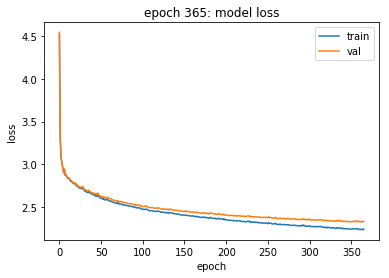

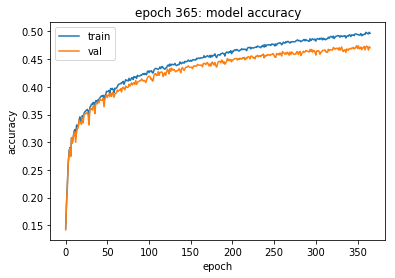



Epoch 366/500 ..............
Loss train:  2.2312070644863566 
Loss val:  2.322273299940817 
Train accuracy:  0.495325 
Validation accuracy:  0.4696
Alpha:  0.001


Epoch 367/500 ..............
Loss train:  2.228946365491653 
Loss val:  2.3205916962565647 
Train accuracy:  0.49835 
Validation accuracy:  0.4757
Alpha:  0.001


Epoch 368/500 ..............
Loss train:  2.227789248516542 
Loss val:  2.3183185634112955 
Train accuracy:  0.49515 
Validation accuracy:  0.4737
Alpha:  0.001


Epoch 369/500 ..............
Loss train:  2.231984272392698 
Loss val:  2.323866658821957 
Train accuracy:  0.497725 
Validation accuracy:  0.4745
Alpha:  0.001


Epoch 370/500 ..............
Loss train:  2.2263359369479807 
Loss val:  2.317821525304824 
Train accuracy:  0.4981 
Validation accuracy:  0.4758
Alpha:  0.001


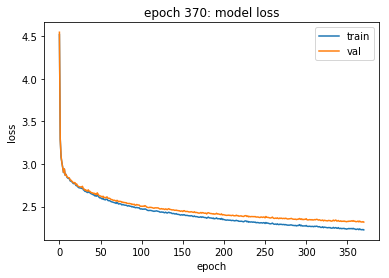

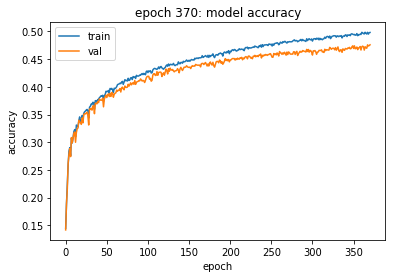



Epoch 371/500 ..............
Loss train:  2.233284184288817 
Loss val:  2.3271503078178433 
Train accuracy:  0.496625 
Validation accuracy:  0.4672
Alpha:  0.001


Epoch 372/500 ..............
Loss train:  2.225168428639252 
Loss val:  2.318588019014406 
Train accuracy:  0.50015 
Validation accuracy:  0.4756
Alpha:  0.001


Epoch 373/500 ..............
Loss train:  2.2230625830107527 
Loss val:  2.317338496736493 
Train accuracy:  0.499425 
Validation accuracy:  0.4738
Alpha:  0.001


Epoch 374/500 ..............
Loss train:  2.227377745737811 
Loss val:  2.317903481886402 
Train accuracy:  0.49725 
Validation accuracy:  0.4723
Alpha:  0.001


Epoch 375/500 ..............
Loss train:  2.2210049633237645 
Loss val:  2.314745936127434 
Train accuracy:  0.499925 
Validation accuracy:  0.4743
Alpha:  0.001


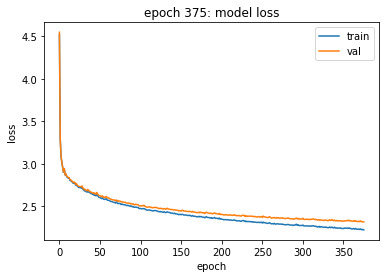

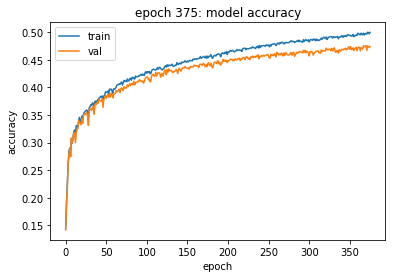



Epoch 376/500 ..............
Loss train:  2.230694670253293 
Loss val:  2.3230524104827213 
Train accuracy:  0.49545 
Validation accuracy:  0.4692
Alpha:  0.001


Epoch 377/500 ..............
Loss train:  2.227390848694501 
Loss val:  2.3191800184465032 
Train accuracy:  0.49585 
Validation accuracy:  0.4733
Alpha:  0.001


Epoch 378/500 ..............
Loss train:  2.229799961953853 
Loss val:  2.3206341134232837 
Train accuracy:  0.495475 
Validation accuracy:  0.4703
Alpha:  0.001


Epoch 379/500 ..............
Loss train:  2.2208897579224156 
Loss val:  2.3147968871638858 
Train accuracy:  0.50145 
Validation accuracy:  0.4761
Alpha:  0.001


Epoch 380/500 ..............
Loss train:  2.220089743054966 
Loss val:  2.31294999573523 
Train accuracy:  0.50115 
Validation accuracy:  0.476
Alpha:  0.001


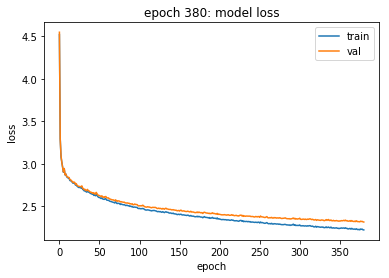

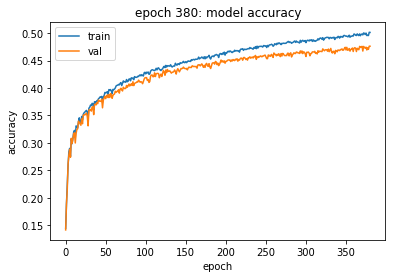



Epoch 381/500 ..............
Loss train:  2.2255026055063927 
Loss val:  2.317556465866302 
Train accuracy:  0.49895 
Validation accuracy:  0.4732
Alpha:  0.001


Epoch 382/500 ..............
Loss train:  2.22184616141318 
Loss val:  2.315955302367254 
Train accuracy:  0.501025 
Validation accuracy:  0.4763
Alpha:  0.001


Epoch 383/500 ..............
Loss train:  2.220175494228693 
Loss val:  2.3156003892494814 
Train accuracy:  0.50165 
Validation accuracy:  0.4748
Alpha:  0.001


Epoch 384/500 ..............
Loss train:  2.216087715459391 
Loss val:  2.311736719854741 
Train accuracy:  0.502025 
Validation accuracy:  0.4738
Alpha:  0.001


Epoch 385/500 ..............
Loss train:  2.2314407579661015 
Loss val:  2.32871324329491 
Train accuracy:  0.498175 
Validation accuracy:  0.4705
Alpha:  0.001


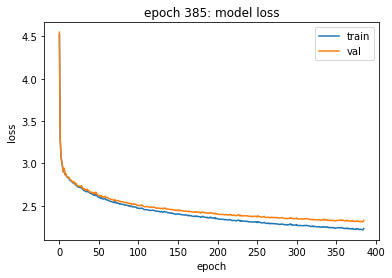

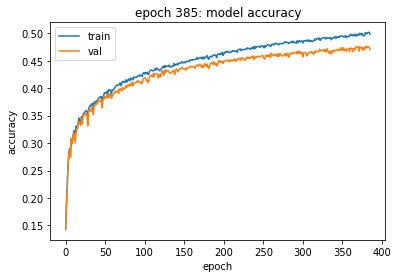



Epoch 386/500 ..............
Loss train:  2.2226186964324244 
Loss val:  2.315344134467322 
Train accuracy:  0.498175 
Validation accuracy:  0.4745
Alpha:  0.001


Epoch 387/500 ..............
Loss train:  2.223656348528143 
Loss val:  2.3185610198160114 
Train accuracy:  0.498525 
Validation accuracy:  0.4726
Alpha:  0.001


Epoch 388/500 ..............
Loss train:  2.220499736850454 
Loss val:  2.3172295579094984 
Train accuracy:  0.50235 
Validation accuracy:  0.4732
Alpha:  0.001


Epoch 389/500 ..............
Loss train:  2.219694259933093 
Loss val:  2.315788548657253 
Train accuracy:  0.499275 
Validation accuracy:  0.4731
Alpha:  0.001


Epoch 390/500 ..............
Loss train:  2.2164206952721015 
Loss val:  2.3145929095733058 
Train accuracy:  0.500975 
Validation accuracy:  0.4729
Alpha:  0.001


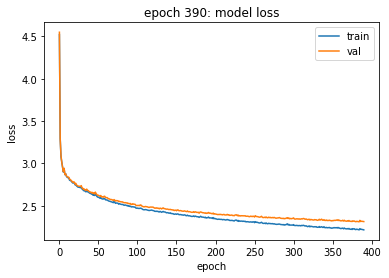

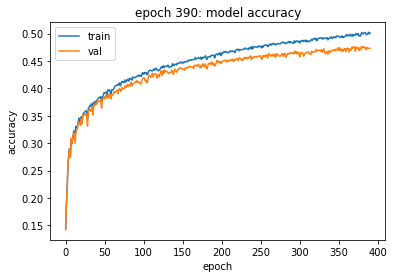



Epoch 391/500 ..............
Loss train:  2.218811150747153 
Loss val:  2.314348914636097 
Train accuracy:  0.501225 
Validation accuracy:  0.4769
Alpha:  0.001


Epoch 392/500 ..............
Loss train:  2.223378511725467 
Loss val:  2.321838216529643 
Train accuracy:  0.499675 
Validation accuracy:  0.4663
Alpha:  0.001


Epoch 393/500 ..............
Loss train:  2.215421994648585 
Loss val:  2.310887014934894 
Train accuracy:  0.50035 
Validation accuracy:  0.4755
Alpha:  0.001


Epoch 394/500 ..............
Loss train:  2.2229690797048844 
Loss val:  2.323120608134905 
Train accuracy:  0.5017 
Validation accuracy:  0.4688
Alpha:  0.001


Epoch 395/500 ..............
Loss train:  2.215101469150569 
Loss val:  2.312225413490297 
Train accuracy:  0.50115 
Validation accuracy:  0.4754
Alpha:  0.001


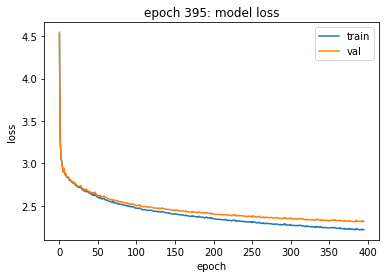

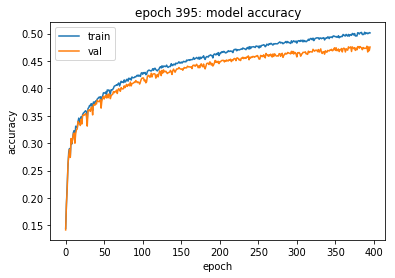



Epoch 396/500 ..............
Loss train:  2.2159702794243614 
Loss val:  2.3132696414156997 
Train accuracy:  0.5025 
Validation accuracy:  0.4775
Alpha:  0.001


Epoch 397/500 ..............
Loss train:  2.217263880471318 
Loss val:  2.315192493898276 
Train accuracy:  0.5012 
Validation accuracy:  0.4738
Alpha:  0.001


Epoch 398/500 ..............
Loss train:  2.214717431691921 
Loss val:  2.3110110060793754 
Train accuracy:  0.500625 
Validation accuracy:  0.4748
Alpha:  0.001


Epoch 399/500 ..............
Loss train:  2.211561326157242 
Loss val:  2.3111044566508667 
Train accuracy:  0.50325 
Validation accuracy:  0.4739
Alpha:  0.001


Epoch 400/500 ..............
Loss train:  2.2178589195657805 
Loss val:  2.31537613325476 
Train accuracy:  0.500025 
Validation accuracy:  0.471
Alpha:  0.001


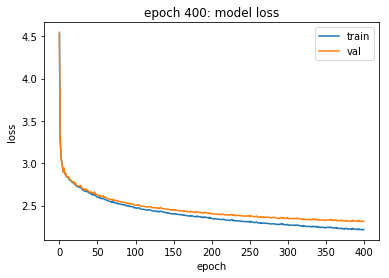

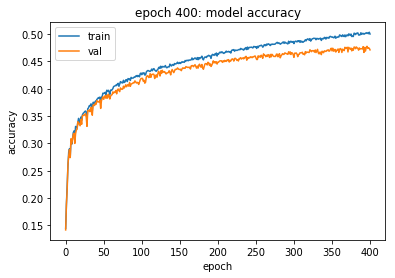



Epoch 401/500 ..............
Loss train:  2.2136243345393662 
Loss val:  2.3109532998404707 
Train accuracy:  0.50145 
Validation accuracy:  0.4767
Alpha:  0.001


Epoch 402/500 ..............
Loss train:  2.209849339579615 
Loss val:  2.3099002534768474 
Train accuracy:  0.503425 
Validation accuracy:  0.4747
Alpha:  0.001


Epoch 403/500 ..............
Loss train:  2.2186502555048593 
Loss val:  2.316619335536174 
Train accuracy:  0.4997 
Validation accuracy:  0.4721
Alpha:  0.001


Epoch 404/500 ..............
Loss train:  2.217484680273216 
Loss val:  2.3156221520691256 
Train accuracy:  0.500575 
Validation accuracy:  0.4744
Alpha:  0.001


Epoch 405/500 ..............
Loss train:  2.215118101141656 
Loss val:  2.3131089299419183 
Train accuracy:  0.50185 
Validation accuracy:  0.4763
Alpha:  0.001


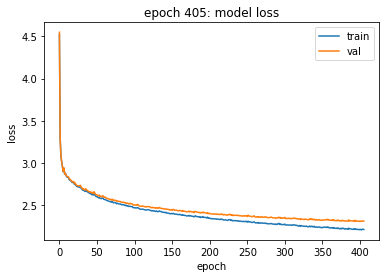

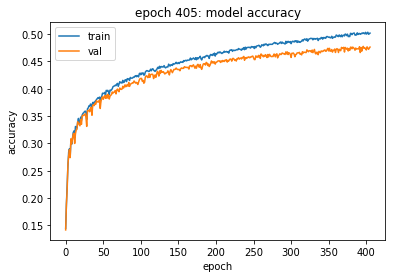



Epoch 406/500 ..............
Loss train:  2.217563976304075 
Loss val:  2.318405134788438 
Train accuracy:  0.5008 
Validation accuracy:  0.472
Alpha:  0.001


Epoch 407/500 ..............
Loss train:  2.2096040796611707 
Loss val:  2.309931640899108 
Train accuracy:  0.50205 
Validation accuracy:  0.4745
Alpha:  0.001


Epoch 408/500 ..............
Loss train:  2.209578269624482 
Loss val:  2.3091186993210218 
Train accuracy:  0.503825 
Validation accuracy:  0.4775
Alpha:  0.001


Epoch 409/500 ..............
Loss train:  2.21676390858886 
Loss val:  2.318308137062989 
Train accuracy:  0.503375 
Validation accuracy:  0.4717
Alpha:  0.001


Epoch 410/500 ..............
Loss train:  2.207811314579931 
Loss val:  2.3063459270316167 
Train accuracy:  0.501225 
Validation accuracy:  0.4765
Alpha:  0.001


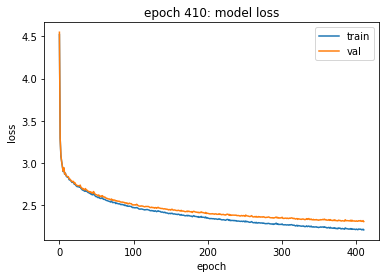

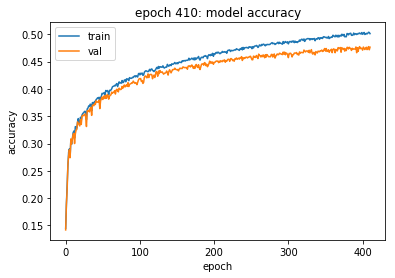



Epoch 411/500 ..............
Loss train:  2.2089551594561385 
Loss val:  2.3073984947649313 
Train accuracy:  0.5008 
Validation accuracy:  0.471
Alpha:  0.001


Epoch 412/500 ..............
Loss train:  2.2065369676452145 
Loss val:  2.3079500083616344 
Train accuracy:  0.505425 
Validation accuracy:  0.4757
Alpha:  0.001


Epoch 413/500 ..............
Loss train:  2.211559326830129 
Loss val:  2.3122996233847046 
Train accuracy:  0.501975 
Validation accuracy:  0.4747
Alpha:  0.001


Epoch 414/500 ..............
Loss train:  2.2066417068672033 
Loss val:  2.3071256685984634 
Train accuracy:  0.5029 
Validation accuracy:  0.4761
Alpha:  0.001


Epoch 415/500 ..............
Loss train:  2.2041669003074595 
Loss val:  2.3032493215957137 
Train accuracy:  0.50595 
Validation accuracy:  0.4787
Alpha:  0.001


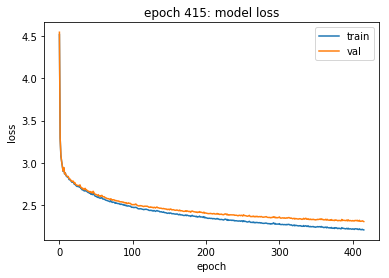

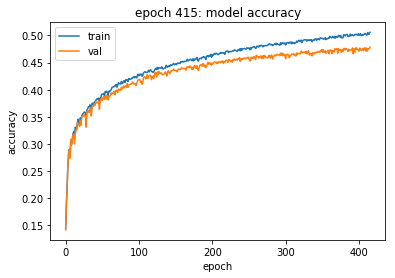



Epoch 416/500 ..............
Loss train:  2.207166532911569 
Loss val:  2.3064533540270404 
Train accuracy:  0.503325 
Validation accuracy:  0.4775
Alpha:  0.001


Epoch 417/500 ..............
Loss train:  2.211597290839116 
Loss val:  2.3150929833933884 
Train accuracy:  0.50245 
Validation accuracy:  0.4661
Alpha:  0.001


Epoch 418/500 ..............
Loss train:  2.207746570220165 
Loss val:  2.311281461829501 
Train accuracy:  0.503025 
Validation accuracy:  0.4708
Alpha:  0.001


Epoch 419/500 ..............
Loss train:  2.207913350622201 
Loss val:  2.3072524370323313 
Train accuracy:  0.50345 
Validation accuracy:  0.4779
Alpha:  0.001


Epoch 420/500 ..............
Loss train:  2.2044567734367346 
Loss val:  2.3057529302015345 
Train accuracy:  0.505075 
Validation accuracy:  0.4746
Alpha:  0.001


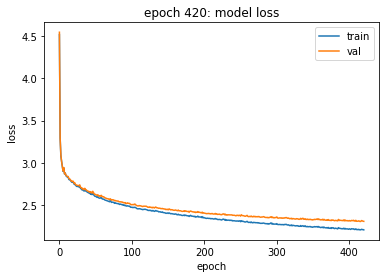

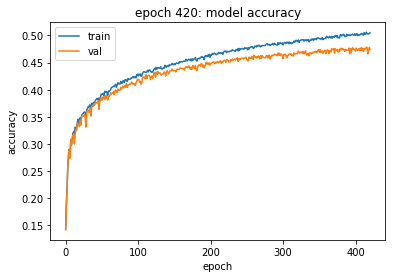



Epoch 421/500 ..............
Loss train:  2.200526336423334 
Loss val:  2.3044105809768114 
Train accuracy:  0.506325 
Validation accuracy:  0.4747
Alpha:  0.001


Epoch 422/500 ..............
Loss train:  2.202768321389839 
Loss val:  2.3041242902335006 
Train accuracy:  0.504075 
Validation accuracy:  0.4767
Alpha:  0.001


Epoch 423/500 ..............
Loss train:  2.2014078469175424 
Loss val:  2.3052667476118986 
Train accuracy:  0.5056 
Validation accuracy:  0.4749
Alpha:  0.001


Epoch 424/500 ..............
Loss train:  2.2153833845423696 
Loss val:  2.3198181612611988 
Train accuracy:  0.50055 
Validation accuracy:  0.4735
Alpha:  0.001


Epoch 425/500 ..............
Loss train:  2.201738351693546 
Loss val:  2.3025136250095444 
Train accuracy:  0.50605 
Validation accuracy:  0.4779
Alpha:  0.001


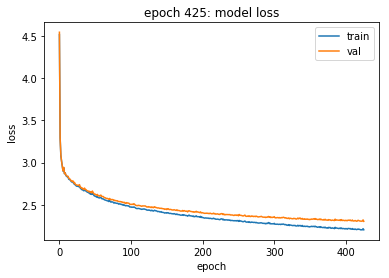

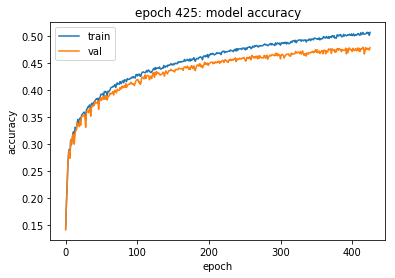



Epoch 426/500 ..............
Loss train:  2.2072652538286763 
Loss val:  2.3081253543731597 
Train accuracy:  0.5045 
Validation accuracy:  0.477
Alpha:  0.001


Epoch 427/500 ..............
Loss train:  2.198068567209535 
Loss val:  2.3020715769139395 
Train accuracy:  0.506125 
Validation accuracy:  0.4786
Alpha:  0.001


Epoch 428/500 ..............
Loss train:  2.1996779221013 
Loss val:  2.3034612524200044 
Train accuracy:  0.507525 
Validation accuracy:  0.4781
Alpha:  0.001


Epoch 429/500 ..............
Loss train:  2.201310350084054 
Loss val:  2.305885956363882 
Train accuracy:  0.50725 
Validation accuracy:  0.4727
Alpha:  0.001


Epoch 430/500 ..............
Loss train:  2.2026331160007686 
Loss val:  2.3033372263331047 
Train accuracy:  0.505975 
Validation accuracy:  0.4794
Alpha:  0.001


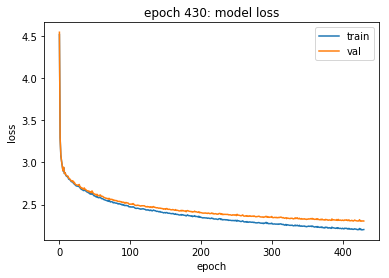

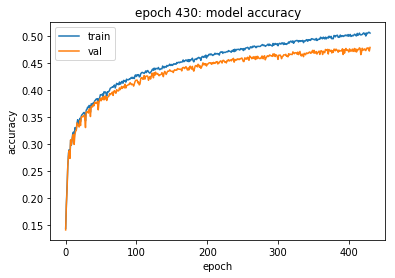



Epoch 431/500 ..............
Loss train:  2.199993430793898 
Loss val:  2.3033576411438497 
Train accuracy:  0.505225 
Validation accuracy:  0.4767
Alpha:  0.001


Epoch 432/500 ..............
Loss train:  2.199584325938015 
Loss val:  2.3035074363002233 
Train accuracy:  0.508 
Validation accuracy:  0.4791
Alpha:  0.001


Epoch 433/500 ..............
Loss train:  2.200944402496198 
Loss val:  2.3053069805373525 
Train accuracy:  0.50415 
Validation accuracy:  0.4781
Alpha:  0.001


Epoch 434/500 ..............
Loss train:  2.202511054831051 
Loss val:  2.3069782168746 
Train accuracy:  0.50585 
Validation accuracy:  0.475
Alpha:  0.001


Epoch 435/500 ..............
Loss train:  2.1960508916501515 
Loss val:  2.3002216565696814 
Train accuracy:  0.504625 
Validation accuracy:  0.4794
Alpha:  0.001


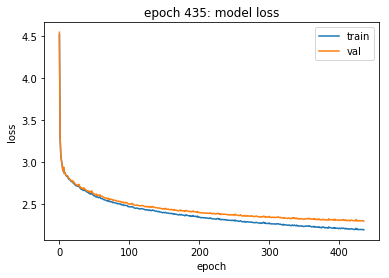

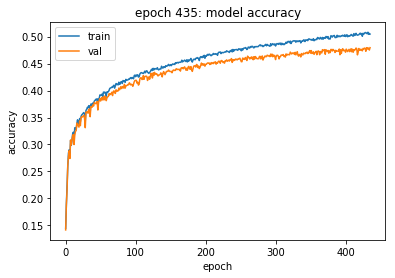



Epoch 436/500 ..............
Loss train:  2.2017250171253435 
Loss val:  2.3065557292520125 
Train accuracy:  0.5059 
Validation accuracy:  0.4778
Alpha:  0.001


Epoch 437/500 ..............
Loss train:  2.1958700917061096 
Loss val:  2.298872663686688 
Train accuracy:  0.50705 
Validation accuracy:  0.4793
Alpha:  0.001


Epoch 438/500 ..............
Loss train:  2.1965765474407717 
Loss val:  2.3020382221852436 
Train accuracy:  0.5049 
Validation accuracy:  0.4791
Alpha:  0.001


Epoch 439/500 ..............
Loss train:  2.200977376872485 
Loss val:  2.306822877412071 
Train accuracy:  0.50955 
Validation accuracy:  0.4797
Alpha:  0.001


Epoch 440/500 ..............
Loss train:  2.1962879756276497 
Loss val:  2.3027906380784553 
Train accuracy:  0.50465 
Validation accuracy:  0.4786
Alpha:  0.001


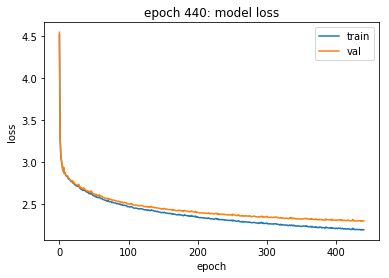

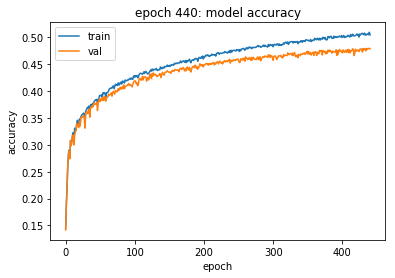



Epoch 441/500 ..............
Loss train:  2.194518564146342 
Loss val:  2.3019177712243373 
Train accuracy:  0.5068 
Validation accuracy:  0.4738
Alpha:  0.001


Epoch 442/500 ..............
Loss train:  2.208307745481307 
Loss val:  2.3109687062276314 
Train accuracy:  0.5041 
Validation accuracy:  0.4797
Alpha:  0.001


Epoch 443/500 ..............
Loss train:  2.198606950888141 
Loss val:  2.306021576673364 
Train accuracy:  0.505525 
Validation accuracy:  0.4761
Alpha:  0.001


Epoch 444/500 ..............
Loss train:  2.1986091661304537 
Loss val:  2.3062663314784992 
Train accuracy:  0.5077 
Validation accuracy:  0.4771
Alpha:  0.001


Epoch 445/500 ..............
Loss train:  2.194029362895079 
Loss val:  2.3009827451690223 
Train accuracy:  0.508025 
Validation accuracy:  0.4776
Alpha:  0.001


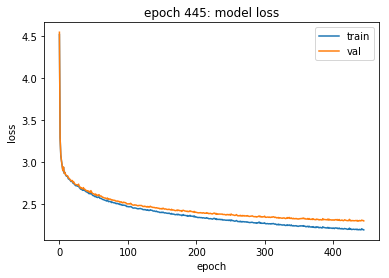

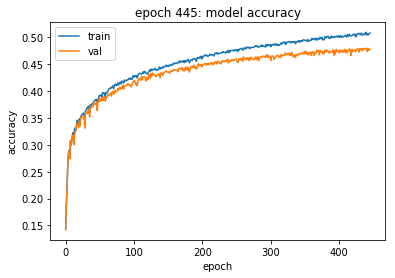



Epoch 446/500 ..............
Loss train:  2.1890220257999458 
Loss val:  2.298906847345578 
Train accuracy:  0.5096 
Validation accuracy:  0.4789
Alpha:  0.001


Epoch 447/500 ..............
Loss train:  2.1913942935764847 
Loss val:  2.299979414431941 
Train accuracy:  0.51 
Validation accuracy:  0.4792
Alpha:  0.001


Epoch 448/500 ..............
Loss train:  2.1956393881037757 
Loss val:  2.3024741427408917 
Train accuracy:  0.508625 
Validation accuracy:  0.4779
Alpha:  0.001


Epoch 449/500 ..............
Loss train:  2.190496552544216 
Loss val:  2.2969971454907747 
Train accuracy:  0.508125 
Validation accuracy:  0.478
Alpha:  0.001


Epoch 450/500 ..............
Loss train:  2.1923034663368717 
Loss val:  2.301669064901694 
Train accuracy:  0.508875 
Validation accuracy:  0.4733
Alpha:  0.001


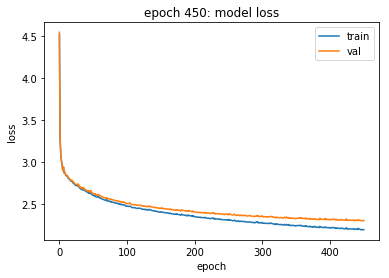

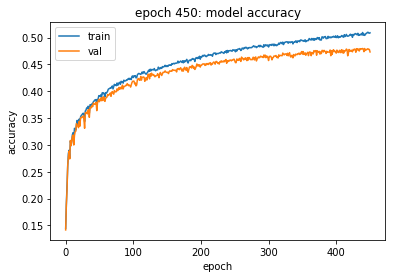



Epoch 451/500 ..............
Loss train:  2.1896640403385517 
Loss val:  2.298096730424842 
Train accuracy:  0.5099 
Validation accuracy:  0.4773
Alpha:  0.001


Epoch 452/500 ..............
Loss train:  2.19040317778087 
Loss val:  2.2981463984845227 
Train accuracy:  0.509475 
Validation accuracy:  0.477
Alpha:  0.001


Epoch 453/500 ..............
Loss train:  2.1879498839577893 
Loss val:  2.2962870573531227 
Train accuracy:  0.509375 
Validation accuracy:  0.4809
Alpha:  0.001


Epoch 454/500 ..............
Loss train:  2.202451959086509 
Loss val:  2.3102404168767405 
Train accuracy:  0.50425 
Validation accuracy:  0.4743
Alpha:  0.001


Epoch 455/500 ..............
Loss train:  2.1893166068600447 
Loss val:  2.298888088006458 
Train accuracy:  0.51115 
Validation accuracy:  0.4792
Alpha:  0.001


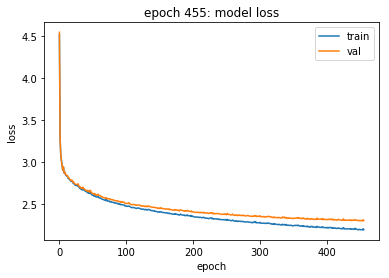

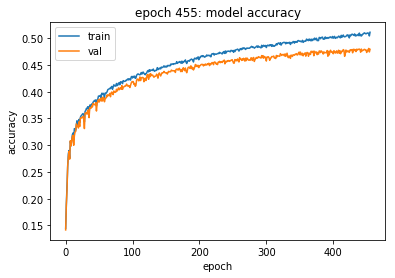



Epoch 456/500 ..............
Loss train:  2.1855438997646295 
Loss val:  2.2955527316737454 
Train accuracy:  0.51015 
Validation accuracy:  0.4789
Alpha:  0.001


Epoch 457/500 ..............
Loss train:  2.1999477632349893 
Loss val:  2.311030954674071 
Train accuracy:  0.507525 
Validation accuracy:  0.4749
Alpha:  0.001


Epoch 458/500 ..............
Loss train:  2.192141252531164 
Loss val:  2.3026762872254363 
Train accuracy:  0.509925 
Validation accuracy:  0.4769
Alpha:  0.001


Epoch 459/500 ..............
Loss train:  2.190241482855097 
Loss val:  2.2991339530479005 
Train accuracy:  0.5081 
Validation accuracy:  0.4827
Alpha:  0.001


Epoch 460/500 ..............
Loss train:  2.1923002583300146 
Loss val:  2.302916598403339 
Train accuracy:  0.50605 
Validation accuracy:  0.4784
Alpha:  0.001


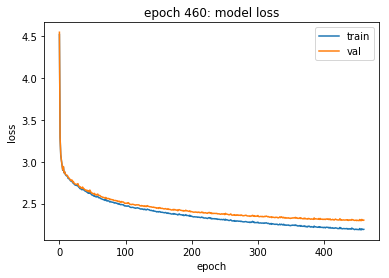

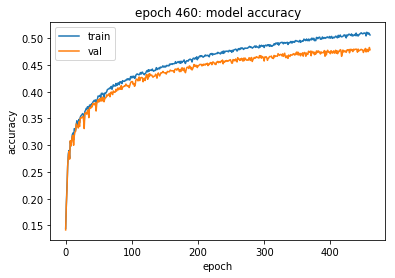



Epoch 461/500 ..............
Loss train:  2.1863593616065957 
Loss val:  2.298031918970217 
Train accuracy:  0.51125 
Validation accuracy:  0.4822
Alpha:  0.001


Epoch 462/500 ..............
Loss train:  2.1889767295779436 
Loss val:  2.2968774877183593 
Train accuracy:  0.5089 
Validation accuracy:  0.4791
Alpha:  0.001


Epoch 463/500 ..............
Loss train:  2.188692223460096 
Loss val:  2.3010314306424426 
Train accuracy:  0.508975 
Validation accuracy:  0.4769
Alpha:  0.001


Epoch 464/500 ..............
Loss train:  2.183655026486953 
Loss val:  2.2953753088115225 
Train accuracy:  0.51115 
Validation accuracy:  0.481
Alpha:  0.001


Epoch 465/500 ..............
Loss train:  2.1854019304026844 
Loss val:  2.296750573710798 
Train accuracy:  0.511525 
Validation accuracy:  0.4777
Alpha:  0.001


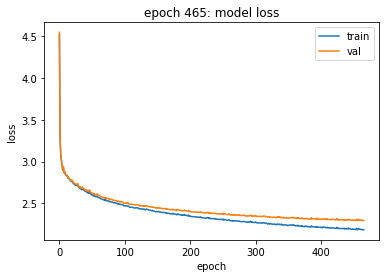

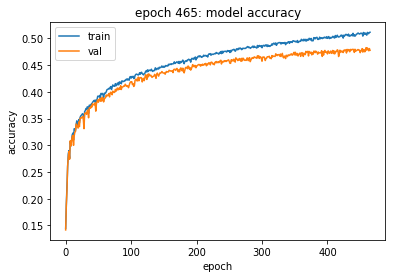



Epoch 466/500 ..............
Loss train:  2.1931386468645715 
Loss val:  2.3028336344671234 
Train accuracy:  0.50845 
Validation accuracy:  0.4806
Alpha:  0.001


Epoch 467/500 ..............
Loss train:  2.1815236955011335 
Loss val:  2.290698732534166 
Train accuracy:  0.512125 
Validation accuracy:  0.4826
Alpha:  0.001


Epoch 468/500 ..............
Loss train:  2.185157799656995 
Loss val:  2.2971924712704035 
Train accuracy:  0.510575 
Validation accuracy:  0.4777
Alpha:  0.001


Epoch 469/500 ..............
Loss train:  2.1801380960203005 
Loss val:  2.2916566908443494 
Train accuracy:  0.5119 
Validation accuracy:  0.4803
Alpha:  0.001


Epoch 470/500 ..............
Loss train:  2.1782431129200357 
Loss val:  2.291180302950404 
Train accuracy:  0.512025 
Validation accuracy:  0.4802
Alpha:  0.001


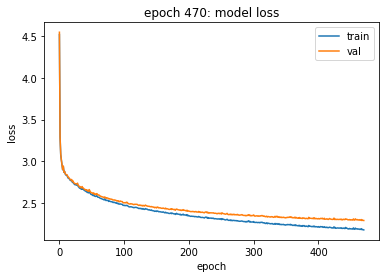

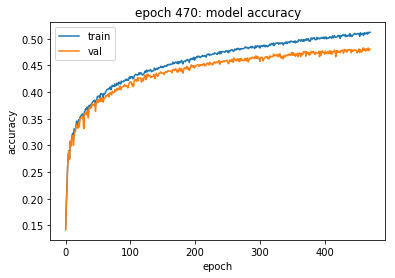



Epoch 471/500 ..............
Loss train:  2.1831418989572215 
Loss val:  2.2969054354872047 
Train accuracy:  0.510525 
Validation accuracy:  0.4767
Alpha:  0.001


Epoch 472/500 ..............
Loss train:  2.183449985701494 
Loss val:  2.2967402789772517 
Train accuracy:  0.510925 
Validation accuracy:  0.4781
Alpha:  0.001


Epoch 473/500 ..............
Loss train:  2.1887396351718165 
Loss val:  2.3020670348038728 
Train accuracy:  0.5097 
Validation accuracy:  0.479
Alpha:  0.001


Epoch 474/500 ..............
Loss train:  2.182376874252711 
Loss val:  2.293548968274802 
Train accuracy:  0.5125 
Validation accuracy:  0.4815
Alpha:  0.001


Epoch 475/500 ..............
Loss train:  2.1793840773556235 
Loss val:  2.2946525749281643 
Train accuracy:  0.511825 
Validation accuracy:  0.4796
Alpha:  0.001


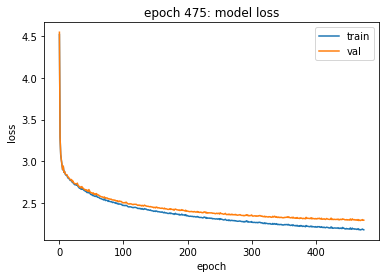

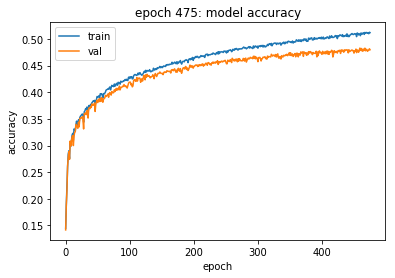



Epoch 476/500 ..............
Loss train:  2.177369839333168 
Loss val:  2.2901351291366234 
Train accuracy:  0.512875 
Validation accuracy:  0.4783
Alpha:  0.001


Epoch 477/500 ..............
Loss train:  2.1808883535784385 
Loss val:  2.2927819724635765 
Train accuracy:  0.5141 
Validation accuracy:  0.481
Alpha:  0.001


Epoch 478/500 ..............
Loss train:  2.1861271160119733 
Loss val:  2.2993109654098816 
Train accuracy:  0.507825 
Validation accuracy:  0.4787
Alpha:  0.001


Epoch 479/500 ..............
Loss train:  2.1836193270763196 
Loss val:  2.294695523560235 
Train accuracy:  0.512625 
Validation accuracy:  0.4832
Alpha:  0.001


Epoch 480/500 ..............
Loss train:  2.1779723652275624 
Loss val:  2.2943935557610606 
Train accuracy:  0.51365 
Validation accuracy:  0.4767
Alpha:  0.001


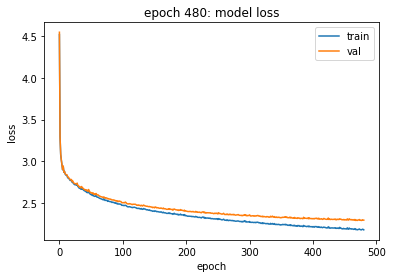

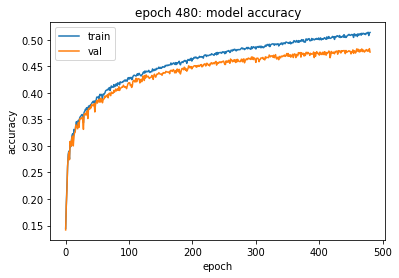



Epoch 481/500 ..............
Loss train:  2.183793096631556 
Loss val:  2.297152366075128 
Train accuracy:  0.50935 
Validation accuracy:  0.4802
Alpha:  0.001


Epoch 482/500 ..............
Loss train:  2.1940534147956683 
Loss val:  2.3084526683419244 
Train accuracy:  0.508525 
Validation accuracy:  0.4769
Alpha:  0.001


Epoch 483/500 ..............
Loss train:  2.176189607959308 
Loss val:  2.2907263123621946 
Train accuracy:  0.51505 
Validation accuracy:  0.4808
Alpha:  0.001


Epoch 484/500 ..............
Loss train:  2.178109980074427 
Loss val:  2.2923707896146217 
Train accuracy:  0.5141 
Validation accuracy:  0.4811
Alpha:  0.001


Epoch 485/500 ..............
Loss train:  2.1776515531845773 
Loss val:  2.290077833819065 
Train accuracy:  0.511275 
Validation accuracy:  0.4811
Alpha:  0.001


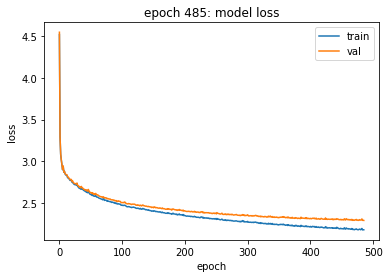

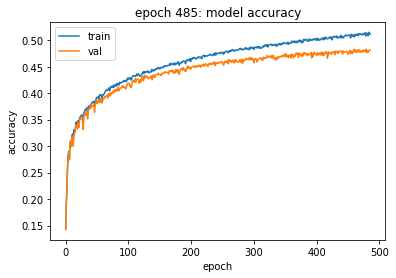



Epoch 486/500 ..............
Loss train:  2.1803618567675698 
Loss val:  2.2936331047784915 
Train accuracy:  0.511525 
Validation accuracy:  0.4812
Alpha:  0.001


Epoch 487/500 ..............
Loss train:  2.1790780999164103 
Loss val:  2.293487092533721 
Train accuracy:  0.511725 
Validation accuracy:  0.4811
Alpha:  0.001


Epoch 488/500 ..............
Loss train:  2.1753070777704266 
Loss val:  2.2898935976597508 
Train accuracy:  0.514675 
Validation accuracy:  0.4804
Alpha:  0.001


Epoch 489/500 ..............
Loss train:  2.1809449593947847 
Loss val:  2.2967620789364442 
Train accuracy:  0.51245 
Validation accuracy:  0.4795
Alpha:  0.001


Epoch 490/500 ..............
Loss train:  2.1807647218317188 
Loss val:  2.2957400772835466 
Train accuracy:  0.510825 
Validation accuracy:  0.4776
Alpha:  0.001


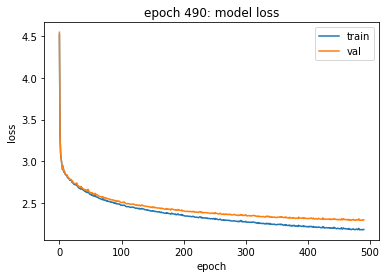

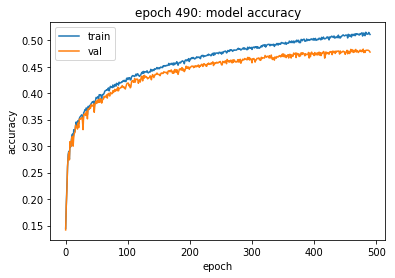



Epoch 491/500 ..............
Loss train:  2.1747055647279807 
Loss val:  2.2904941682192015 
Train accuracy:  0.513025 
Validation accuracy:  0.4776
Alpha:  0.001


Epoch 492/500 ..............
Loss train:  2.1751481648447686 
Loss val:  2.290855369372071 
Train accuracy:  0.514525 
Validation accuracy:  0.4773
Alpha:  0.001


Epoch 493/500 ..............
Loss train:  2.1718225651855643 
Loss val:  2.2870347174578365 
Train accuracy:  0.515175 
Validation accuracy:  0.4809
Alpha:  0.001


Epoch 494/500 ..............
Loss train:  2.1770006194936684 
Loss val:  2.293378251867955 
Train accuracy:  0.51245 
Validation accuracy:  0.4791
Alpha:  0.001


Epoch 495/500 ..............
Loss train:  2.173228968800862 
Loss val:  2.2887277607886274 
Train accuracy:  0.51165 
Validation accuracy:  0.48
Alpha:  0.001


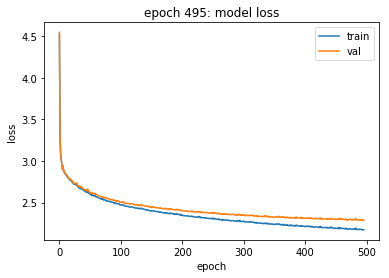

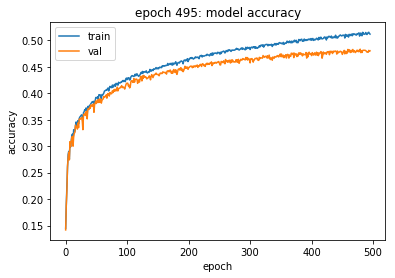



Epoch 496/500 ..............
Loss train:  2.175121703315285 
Loss val:  2.293232790714551 
Train accuracy:  0.51265 
Validation accuracy:  0.4768
Alpha:  0.001


Epoch 497/500 ..............
Loss train:  2.1769208126570603 
Loss val:  2.294347254702442 
Train accuracy:  0.51205 
Validation accuracy:  0.4775
Alpha:  0.001


Epoch 498/500 ..............
Loss train:  2.174916428986886 
Loss val:  2.290711300139648 
Train accuracy:  0.51415 
Validation accuracy:  0.4815
Alpha:  0.001


Epoch 499/500 ..............
Loss train:  2.1715609953708577 
Loss val:  2.288036968239694 
Train accuracy:  0.514675 
Validation accuracy:  0.4799
Alpha:  0.001


In [31]:
batch_size = 1024
dropout_prob = 0.7
num_epochs = 500
alpha = 0.1
history_loss_train,history_loss_val, history_acc_train, history_acc_val = [],[],[],[]
num_train_samples = x_train.shape[0]
num_batches = num_train_samples // batch_size
layers_size = [3072, 16, 256 ,10]
#thetas = np.asarray([np.random.randn(layers_size[i], layers_size[i+1]) for i in range(0, len(layers_size)-1)])
thetas = init_thetas(layers_size)
y_pred = forward(thetas, x_train,dropout_prob, False)
loss_val = loss(y_train, y_pred[-1])
print("Initial loss :", loss_val)
Et = np.asarray([np.zeros(th.shape) for th in thetas])
RMS = np.asarray([np.zeros(th.shape) for th in thetas])
for i in range(0, num_epochs):
    p = np.random.permutation(num_train_samples)
    print('\n\nEpoch %d/%d ' % (i, num_epochs), end='.')
    for batch_no in range(0, num_batches):
        if np.mod(batch_no, num_batches // 10) == 0:
            print('.', end='')
            sys.stdout.flush()
        
        x_train_batch = x_train[p[batch_no * batch_size : (batch_no + 1) * batch_size], :]
        y_train_batch = y_train[p[batch_no * batch_size: (batch_no + 1) * batch_size]]
        d_theta = backward(x_train_batch, y_train_batch, thetas,dropout_prob)
        
        for j in range(0,len(d_theta)):
            Et[j], RMS[j], delta = Adadelta(Et[j], d_theta[j], 0.99, RMS[j], 10**-8) #Adadelta
            #Et[j], delta = RMSprob(Et[j], d_theta[j], 0.9, alpha, 10**-8) #RMSprop
            #thetas[j] =thetas[j] - alpha*d_theta[j] #Обычный mini-batch BackProp
            thetas[j] = thetas[j] - delta 
  
    #loss train
    pred_train_probs = forward(thetas, x_train,dropout_prob, False)
    y_train_out = pred_train_probs[-1]
    loss_train = loss(y_train,  y_train_out)
    history_loss_train.append(loss_train)
    
    #loss val
    pred_val_probs = forward(thetas, x_val,dropout_prob, False)
    y_val_out = pred_val_probs[-1]
    loss_val = loss(y_val, y_val_out)
    history_loss_val.append(loss_val)
    
    history_acc_train.append(acc(y_train, y_train_out))
    history_acc_val.append(acc(y_val, y_val_out))
    print("\nLoss train: ", loss_train,
          "\nLoss val: ", loss_val,
          "\nTrain accuracy: ",acc(y_train, y_train_out),
          "\nValidation accuracy: ", acc(y_val, y_val_out))
    print("Alpha: ", alpha)
    #alpha = max(0.00001, alpha * 0.5)#изменение шага градиента (сначала идем большими, постепенно уменьшая)
    if len(history_loss_val) >= 2:
        if history_loss_val[-2] - history_loss_val[-1] < 0.0005:
            alpha = max(alpha/2, 0.001)
    if (np.mod(i, num_epochs // (num_epochs/5)) == 0) and i != 0:#каждые 10 выводим на экран
        plt.plot(history_loss_train)
        plt.plot(history_loss_val)
        plt.title(f'epoch {i}: model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper right')
        plt.show()

        plt.plot(history_acc_train)
        plt.plot(history_acc_val)
        plt.title(f'epoch {i}: model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()


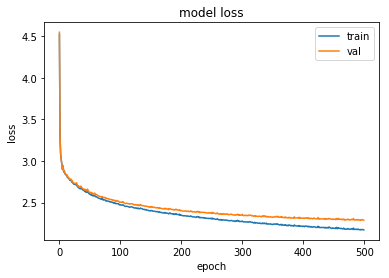

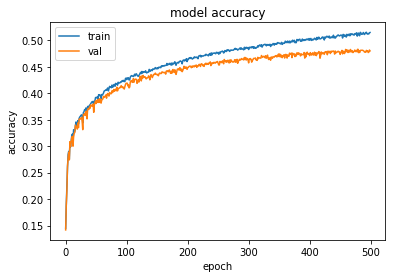

In [32]:
plt.plot(history_loss_train)
plt.plot(history_loss_val)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

plt.plot(history_acc_train)
plt.plot(history_acc_val)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [33]:
pred_test_probs = forward(thetas, x_test,dropout_prob, False)
y_test_out = pred_test_probs[-1]
loss_test = loss(y_test, y_test_out)
print("\nLoss test:", loss_test,
          "\nTest accuracy : ",acc(y_test, y_test_out))


Loss test: 2.284229834909512 
Test accuracy :  0.4857


In [34]:
import pickle
pickle.dump(thetas, open('weights\\thetasTwoHidLay16-256_Adadelta_500epochs.pkl', 'wb'))

In [35]:
f = open('results_Khayrkina5710M.txt','w')
for y in y_test_out:
    f.write(str(np.argmax(y))+'\n')
f.close()